# Analytics - Product Quality 

#### Date: 2020/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2023/01
##### Professor: Hilmer Neri

##### Members:

- Aline Lermen
- Caio Martins
- Dafne Moretti
- João Pedro
- João Vitor
- Lucas Gabriel
- Lucas Lima
- Eric Camargo
- Ester Flores
- Leonardo Ferreira
- Luana Torres
- Matheus Ferreira
- Pablo Guilherme
- Pedro Izarias
- Pedro Sena
- Suzane Duarte

##### Data de análise: [R1] -  26/05/2023 (Sprint 04)


### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [4]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2023-1-Alectrion-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'EquipamentApi': 'ts',
    'Gateway': 'ts',
    'UserAPI': 'ts',
    'FrontEnd': 'ts',
}

### SonarCloud
##### Path to the folder with all your jsons

In [5]:
# Maybe you should change this path to your own path

sonar_files = glob('../analytics-raw-data/*.json')

## Create DataFrame

#### Unmarshall json

In [6]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [7]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [8]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [9]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [10]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [11]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [12]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

array(['fga-eps-mds-2023-1-Alectrion-EquipamentApi',
       'fga-eps-mds-2023-1-Alectrion-FrontEnd',
       'fga-eps-mds-2023-1-Alectrion-Gateway',
       'fga-eps-mds-2023-1-Alectrion-UserAPI'], dtype=object)

### Create dataframe per repository

In [13]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [14]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [15]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [16]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [17]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [18]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [19]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [20]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [21]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [22]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

## Data visualization

In this area you will need to plot the metrics of each repository.

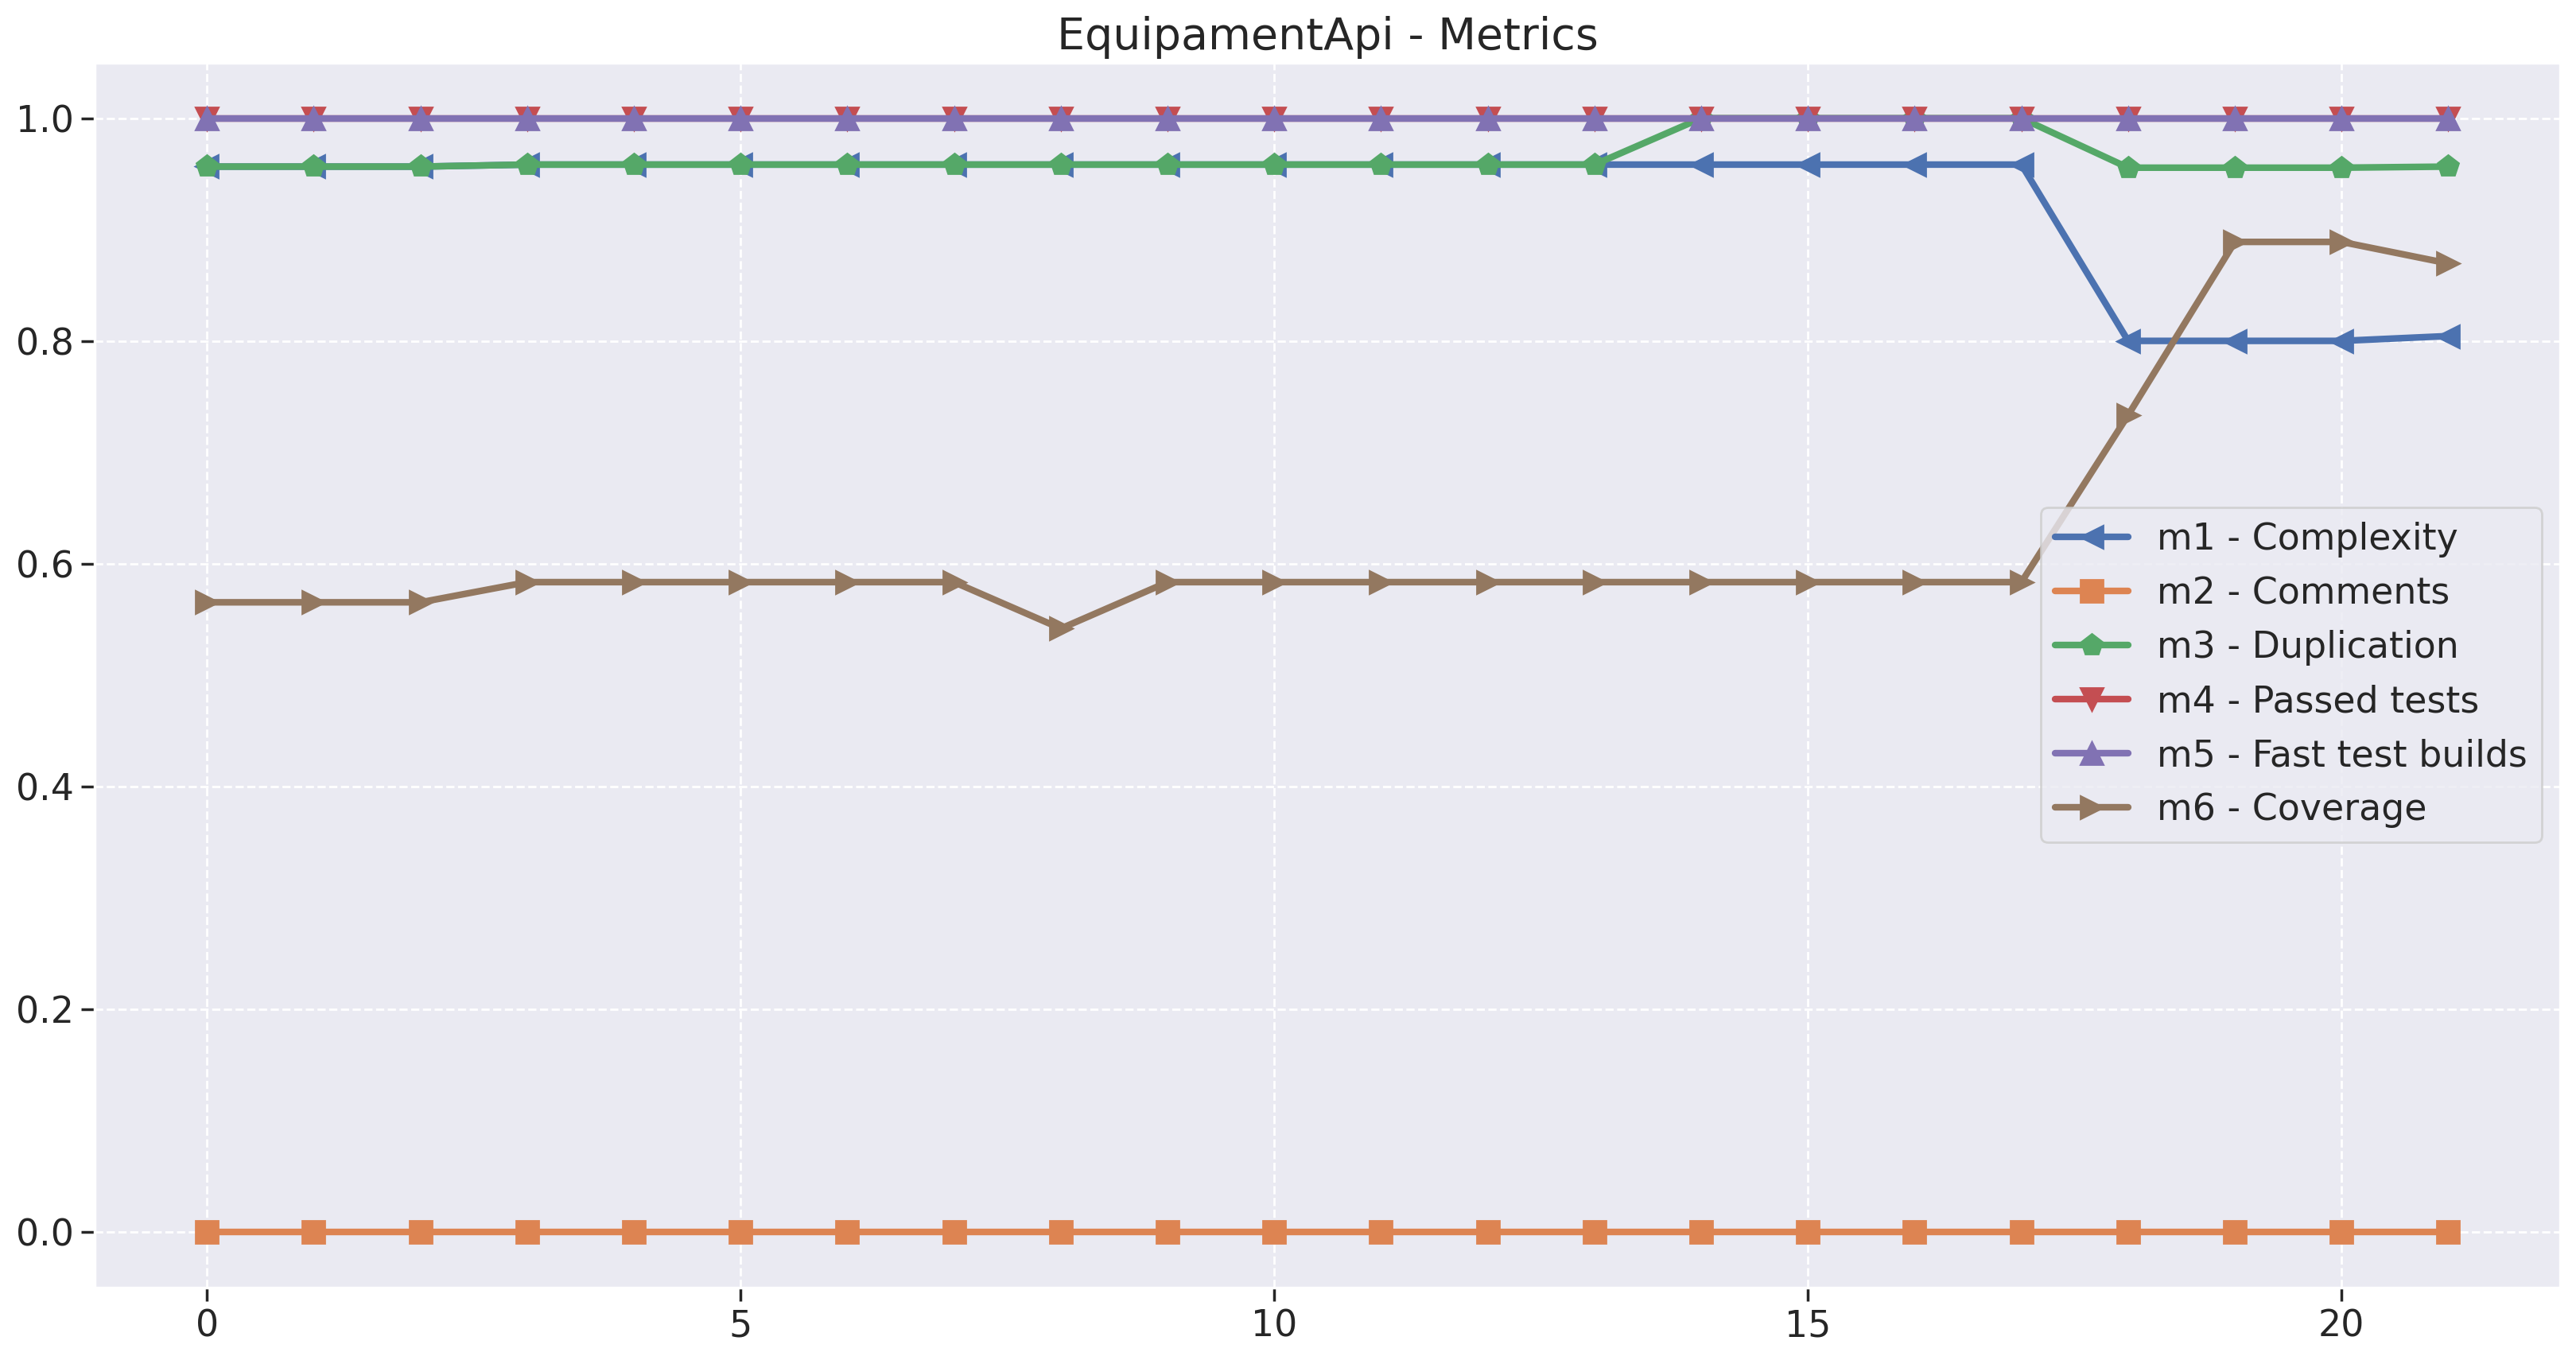

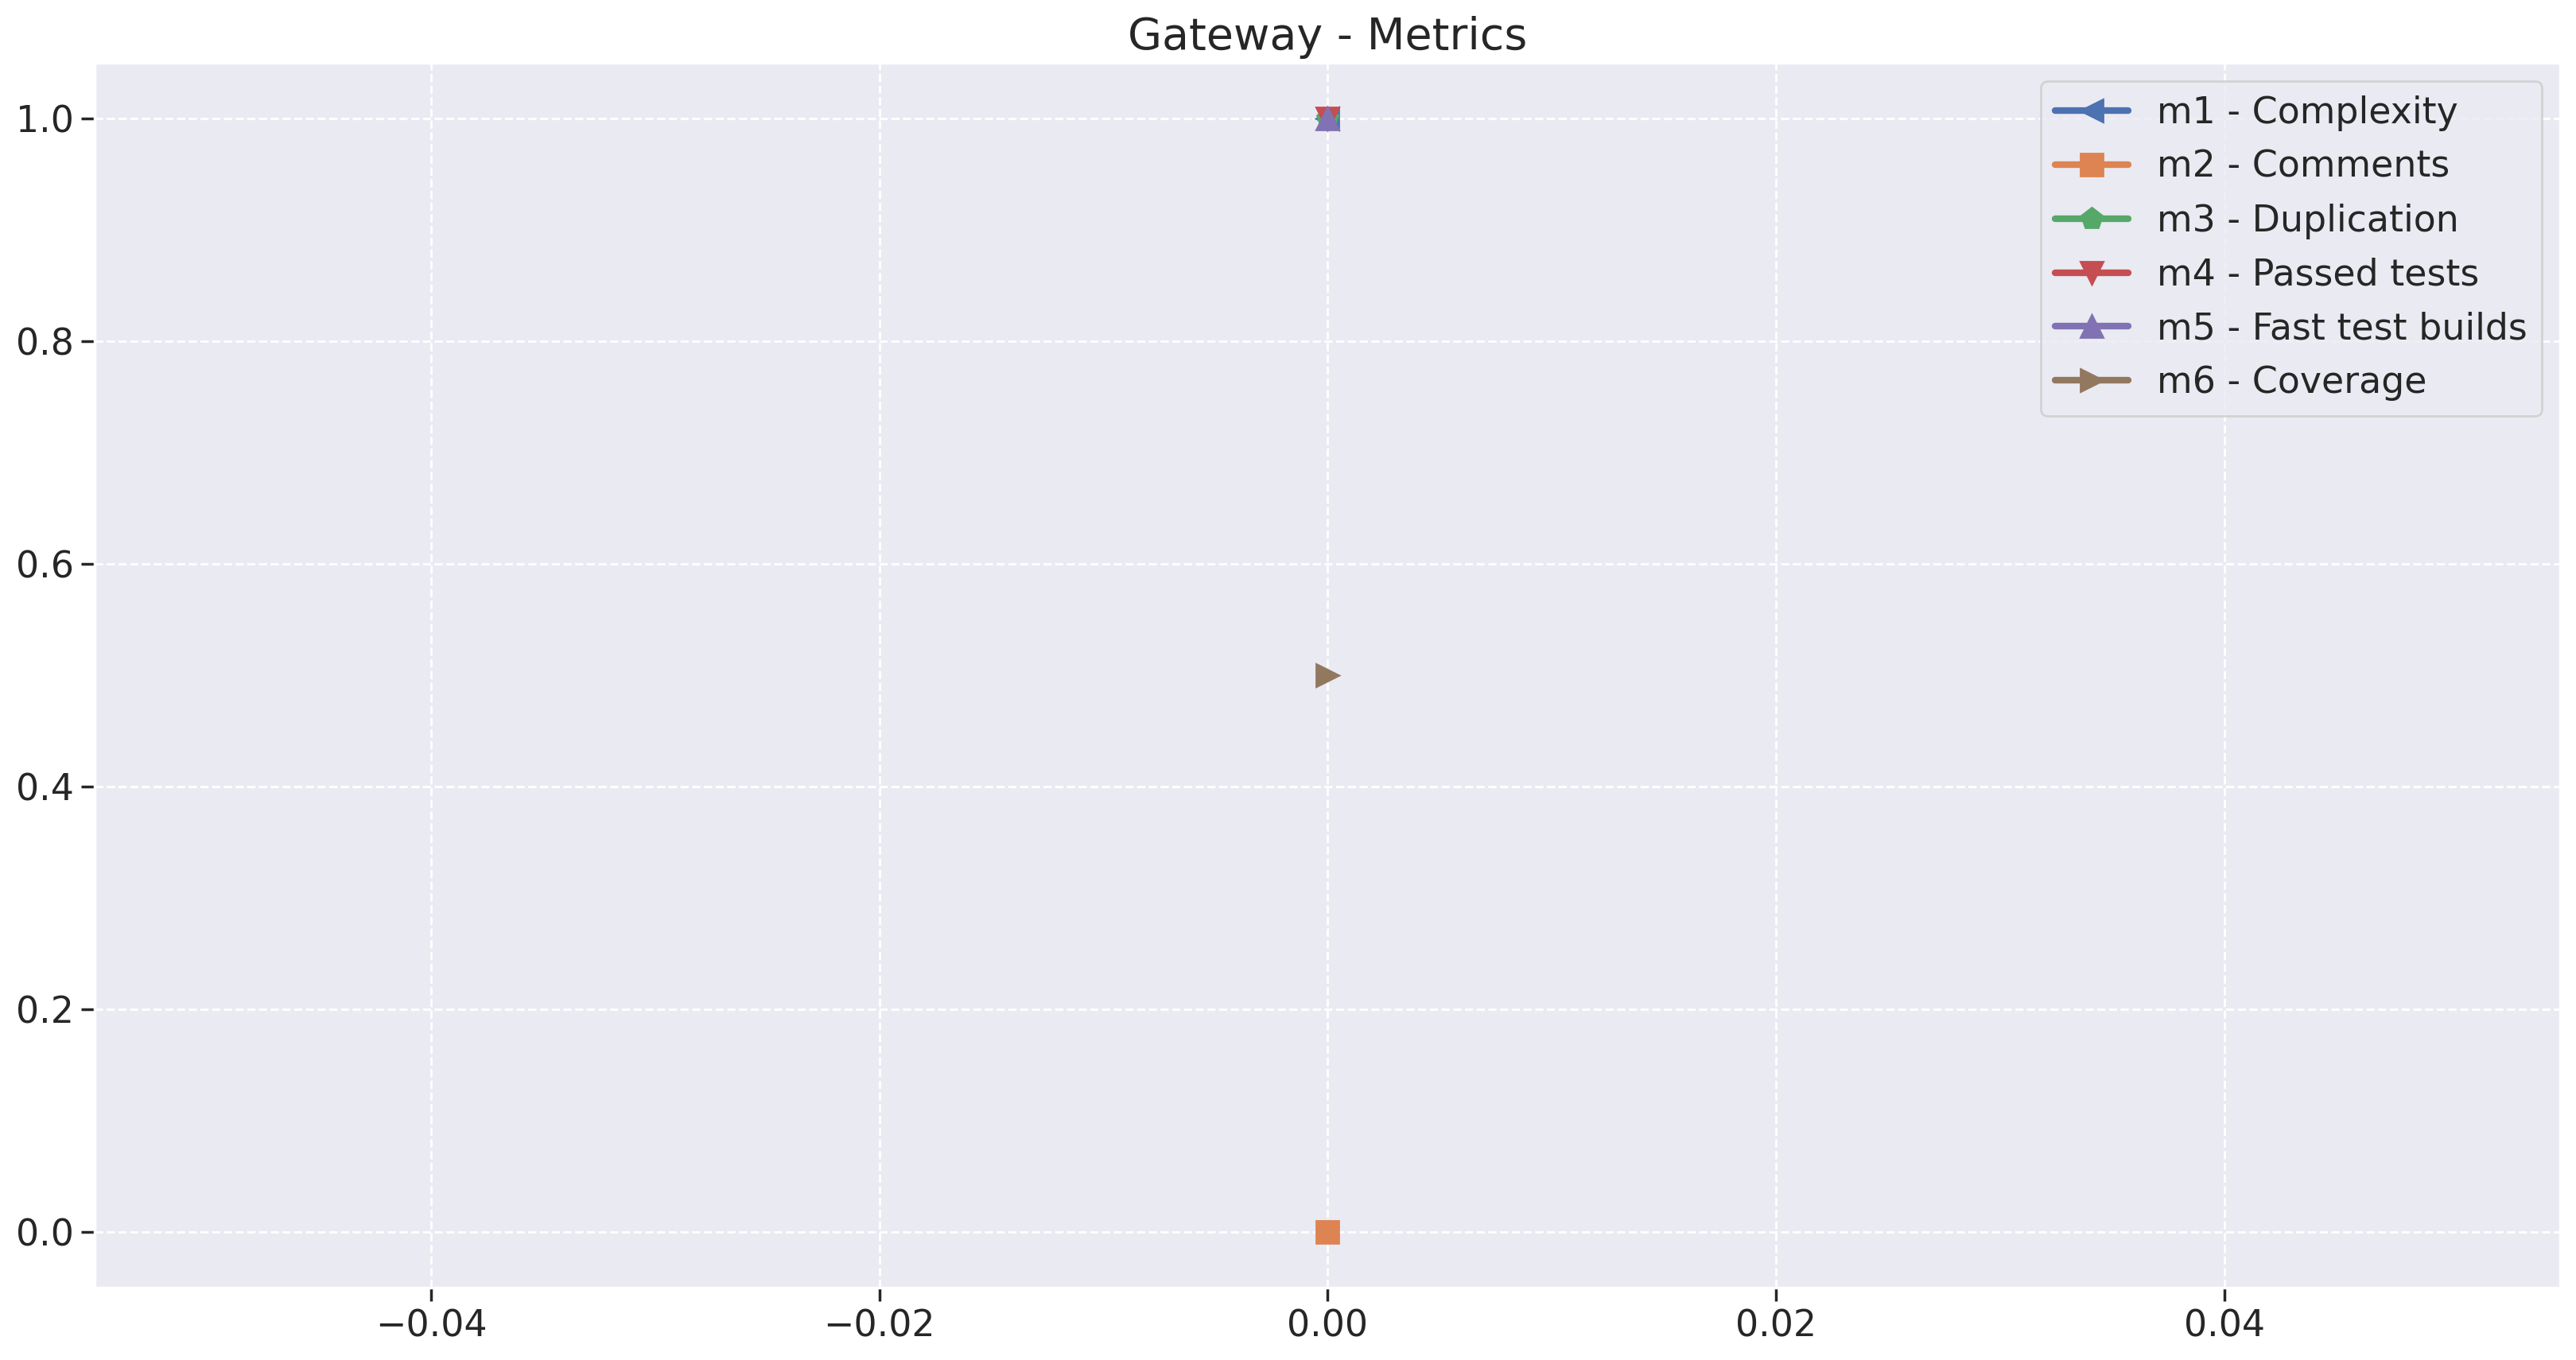

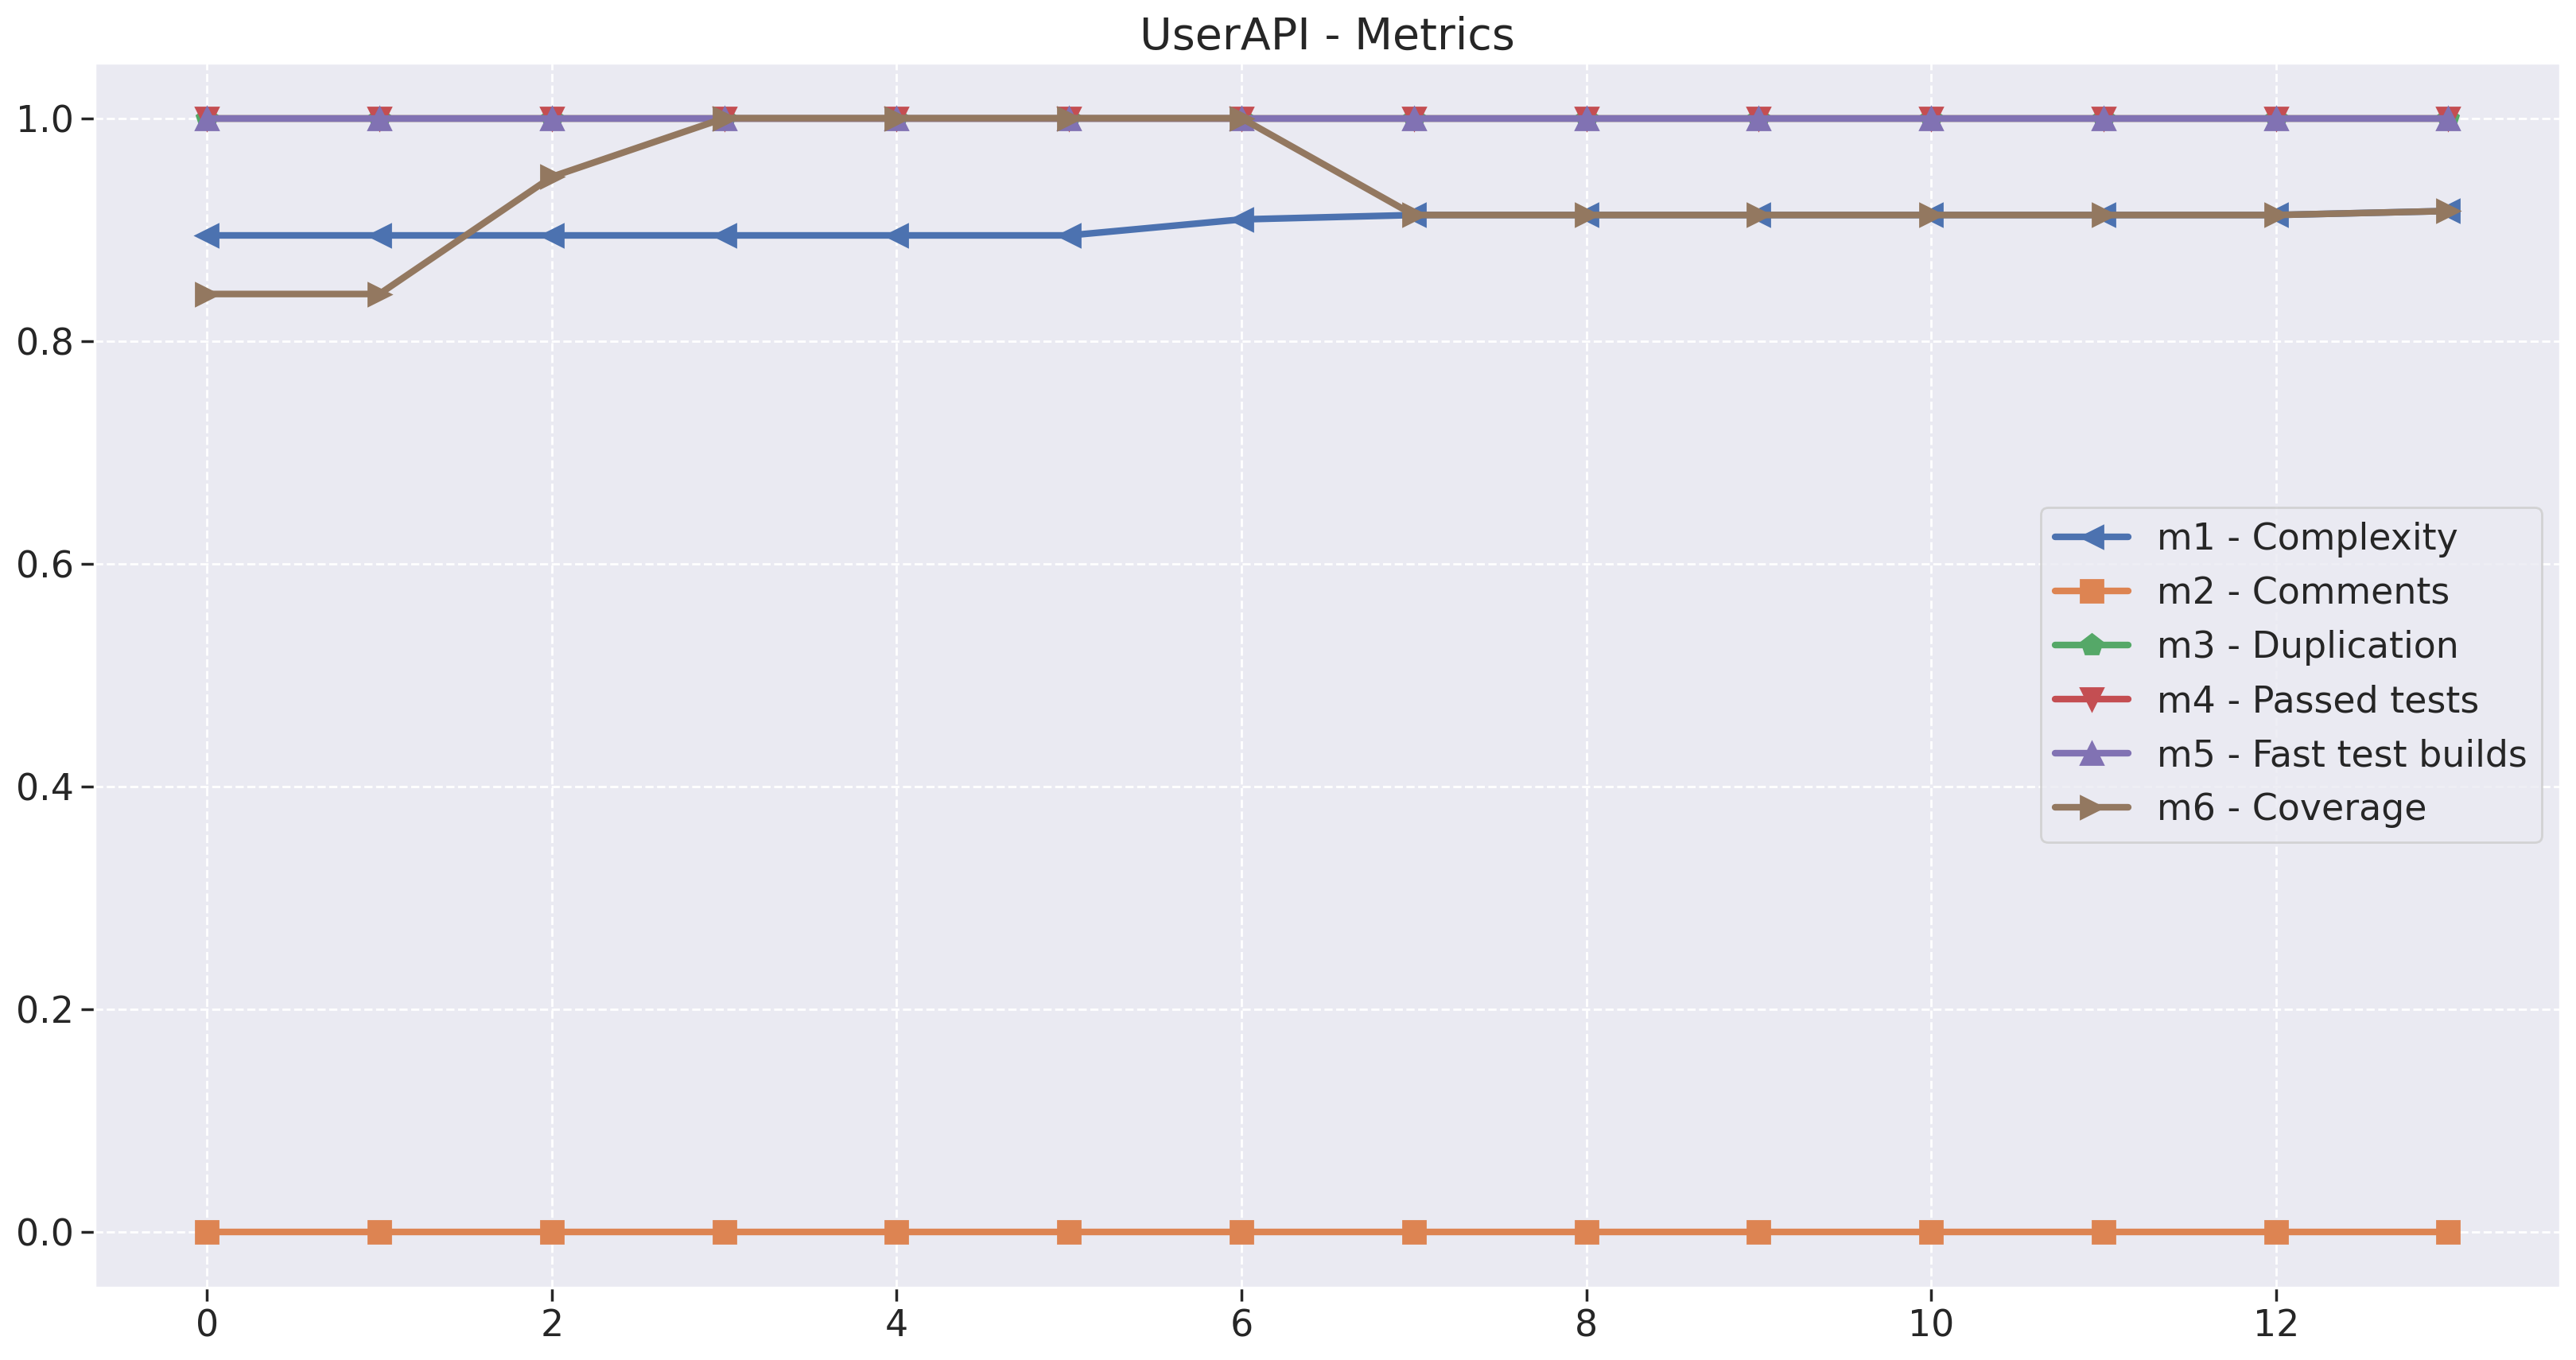

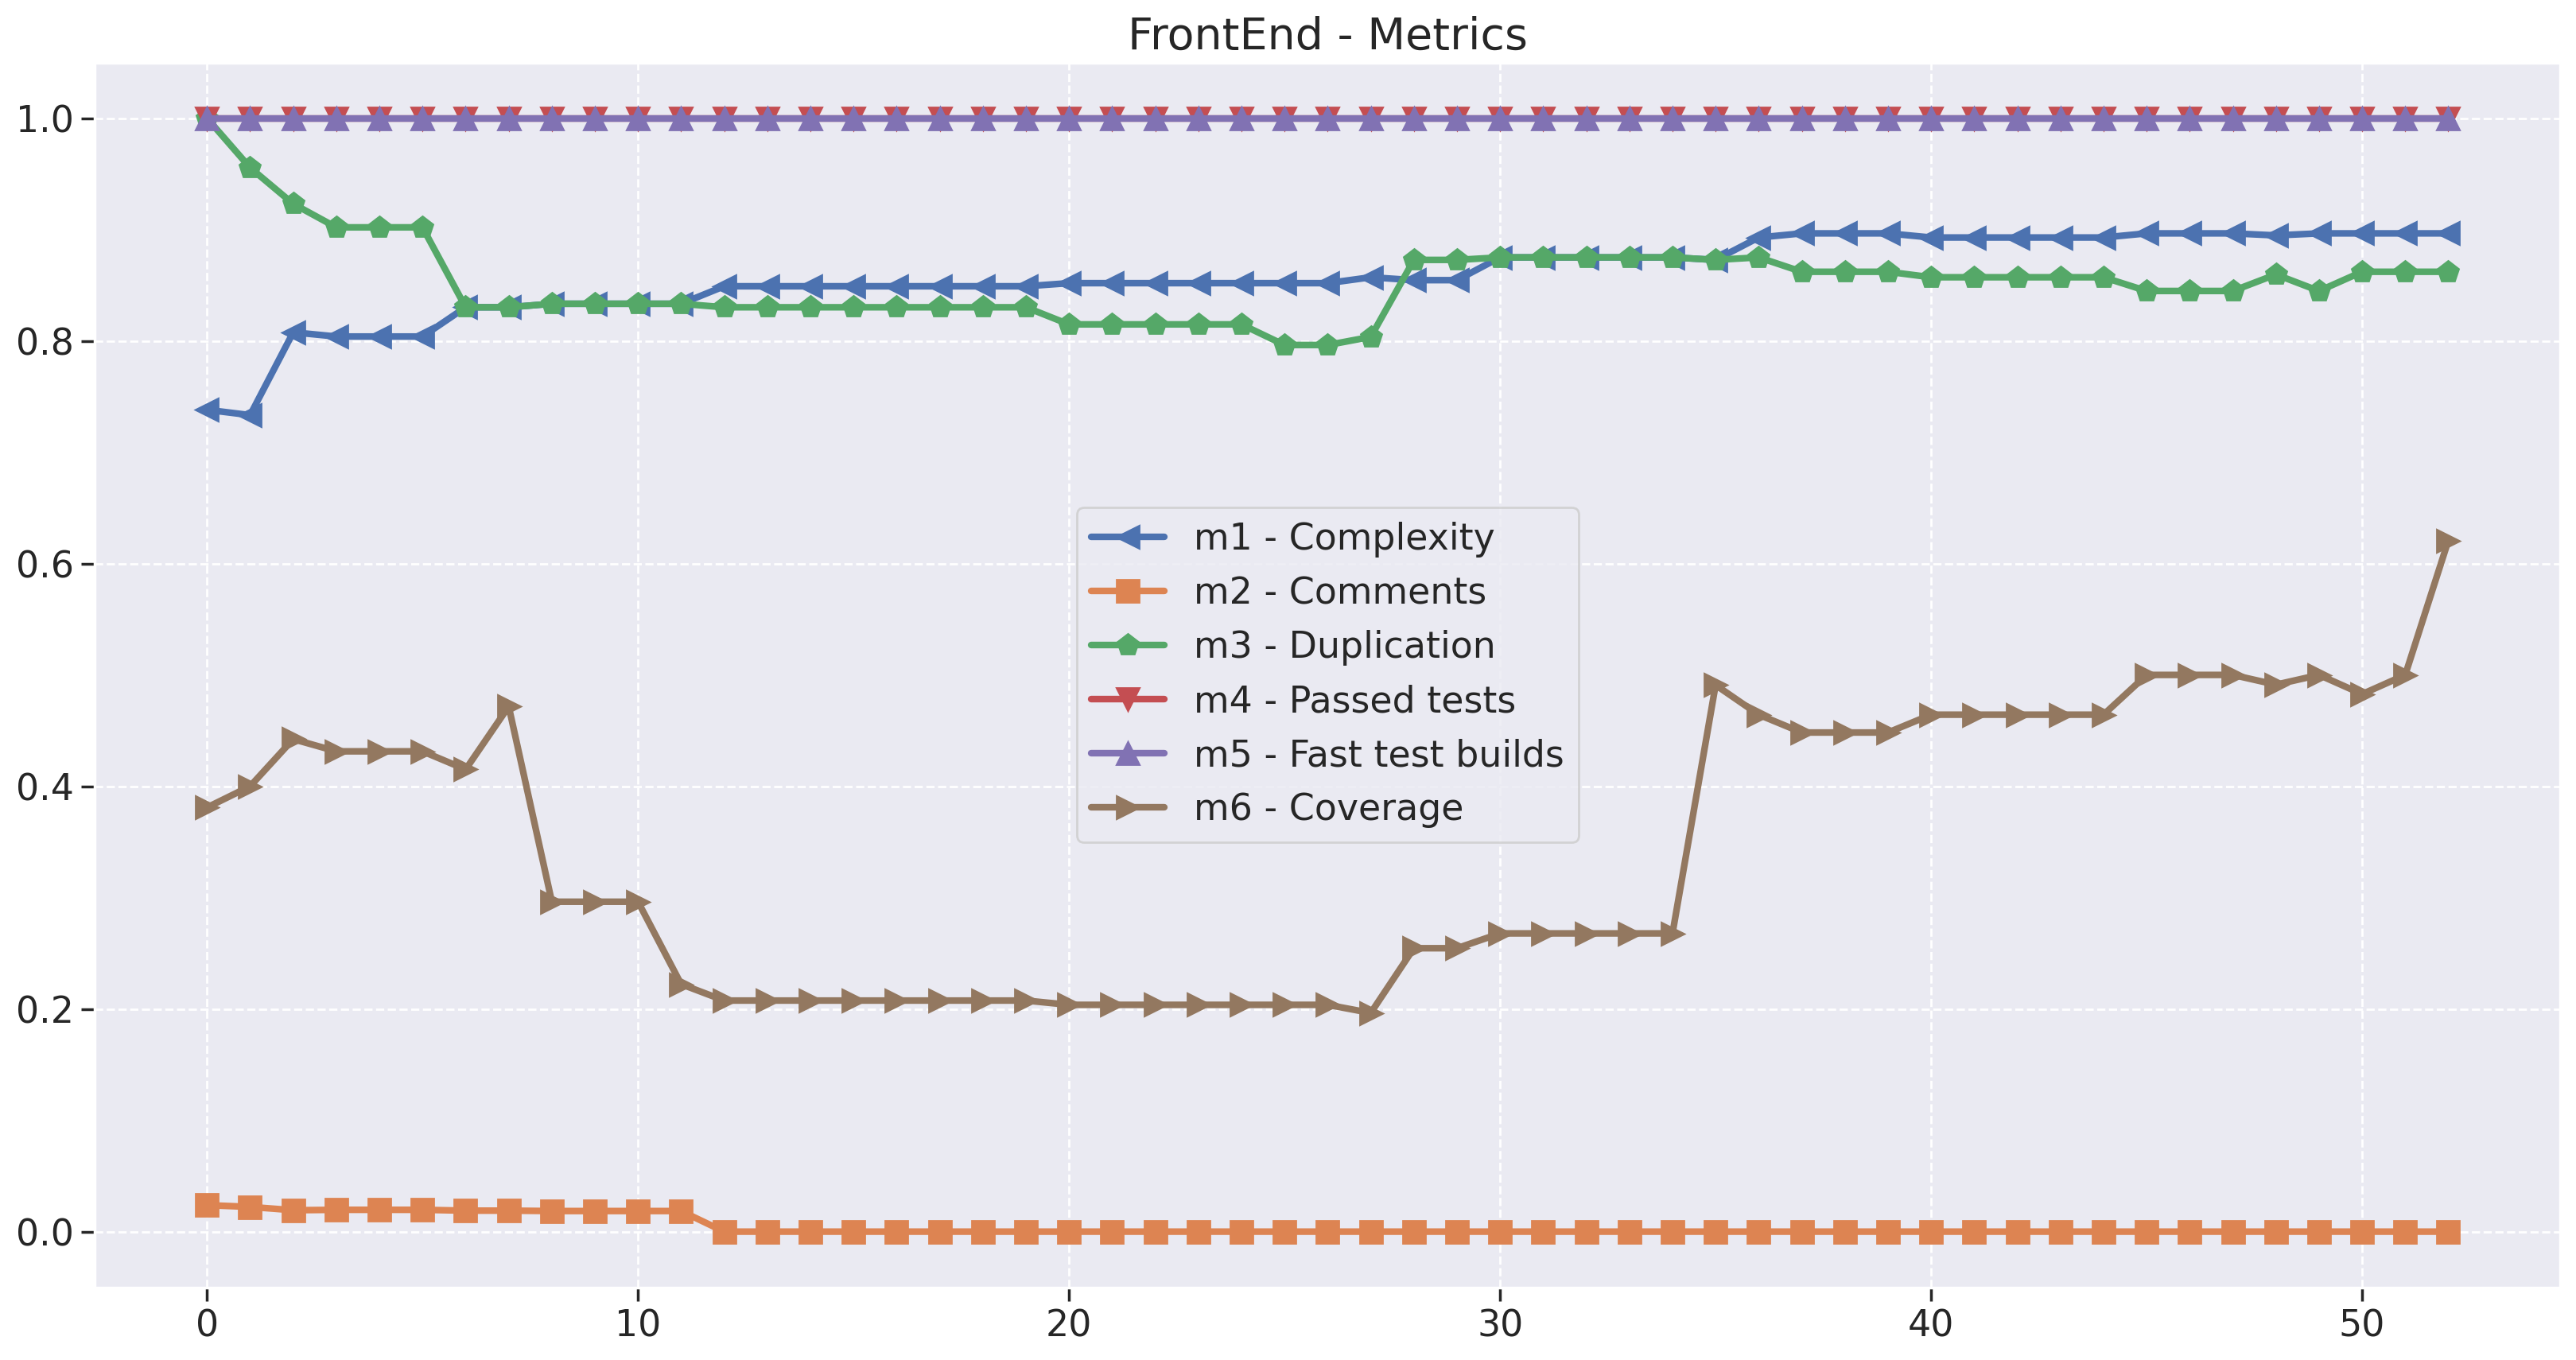

In [23]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=10, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=10, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [24]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

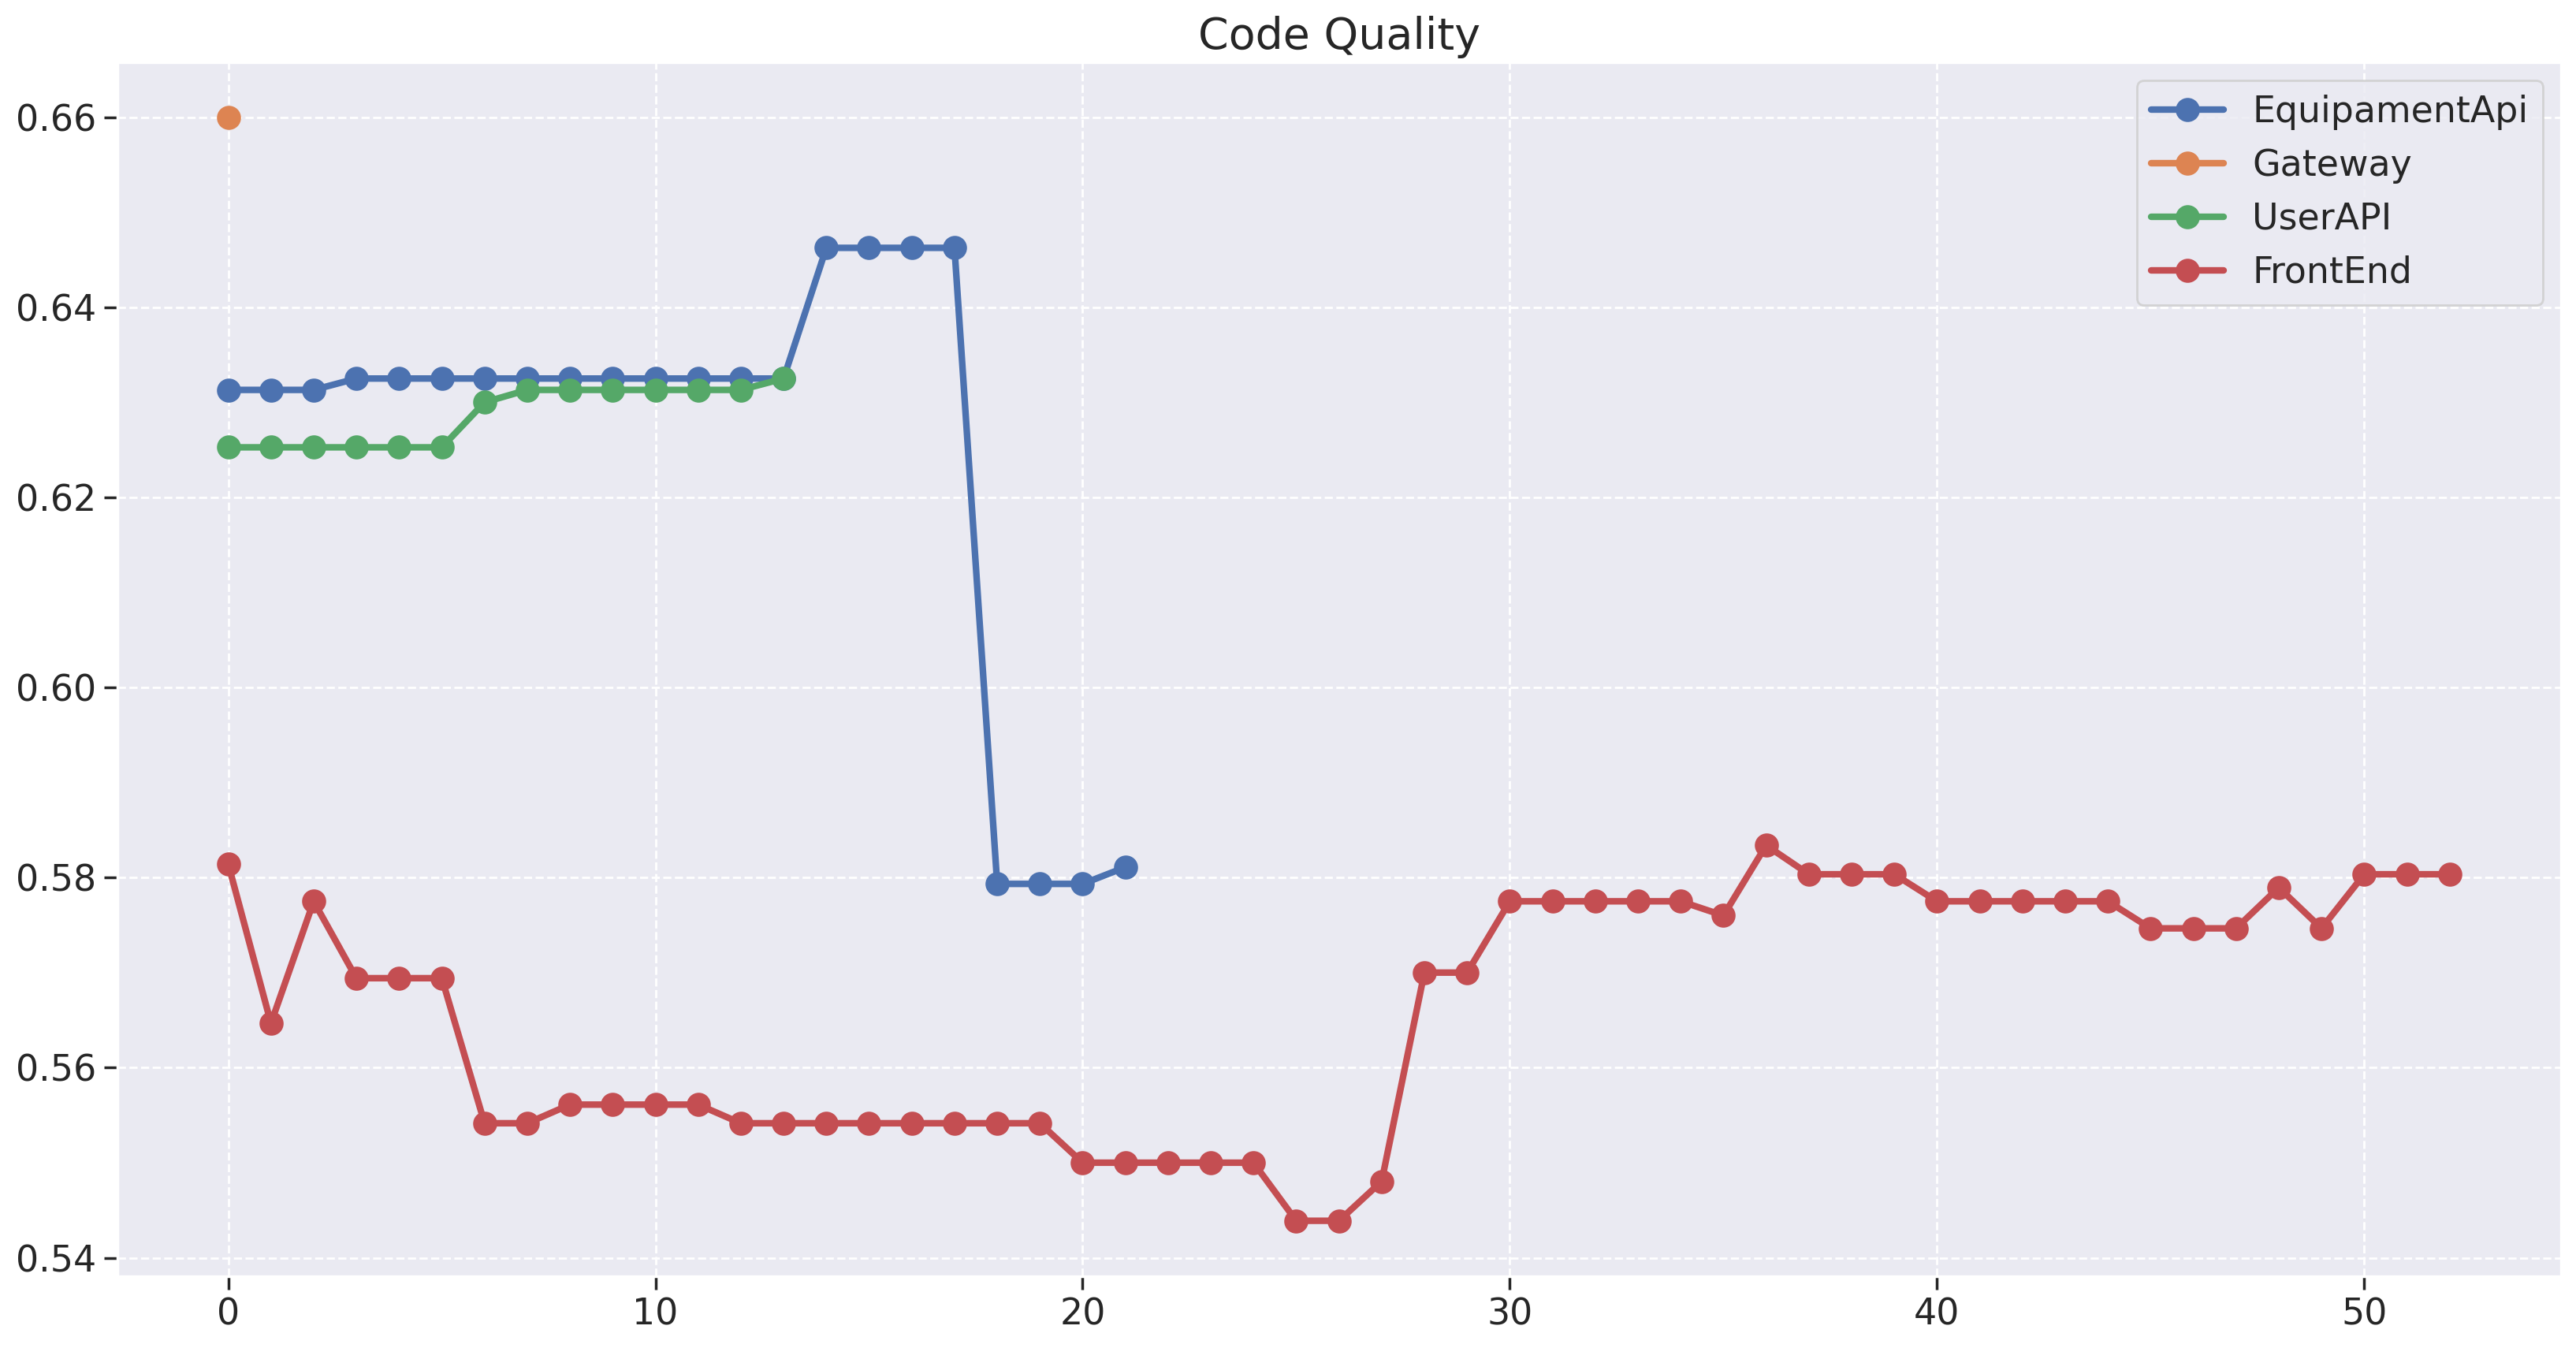

In [25]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

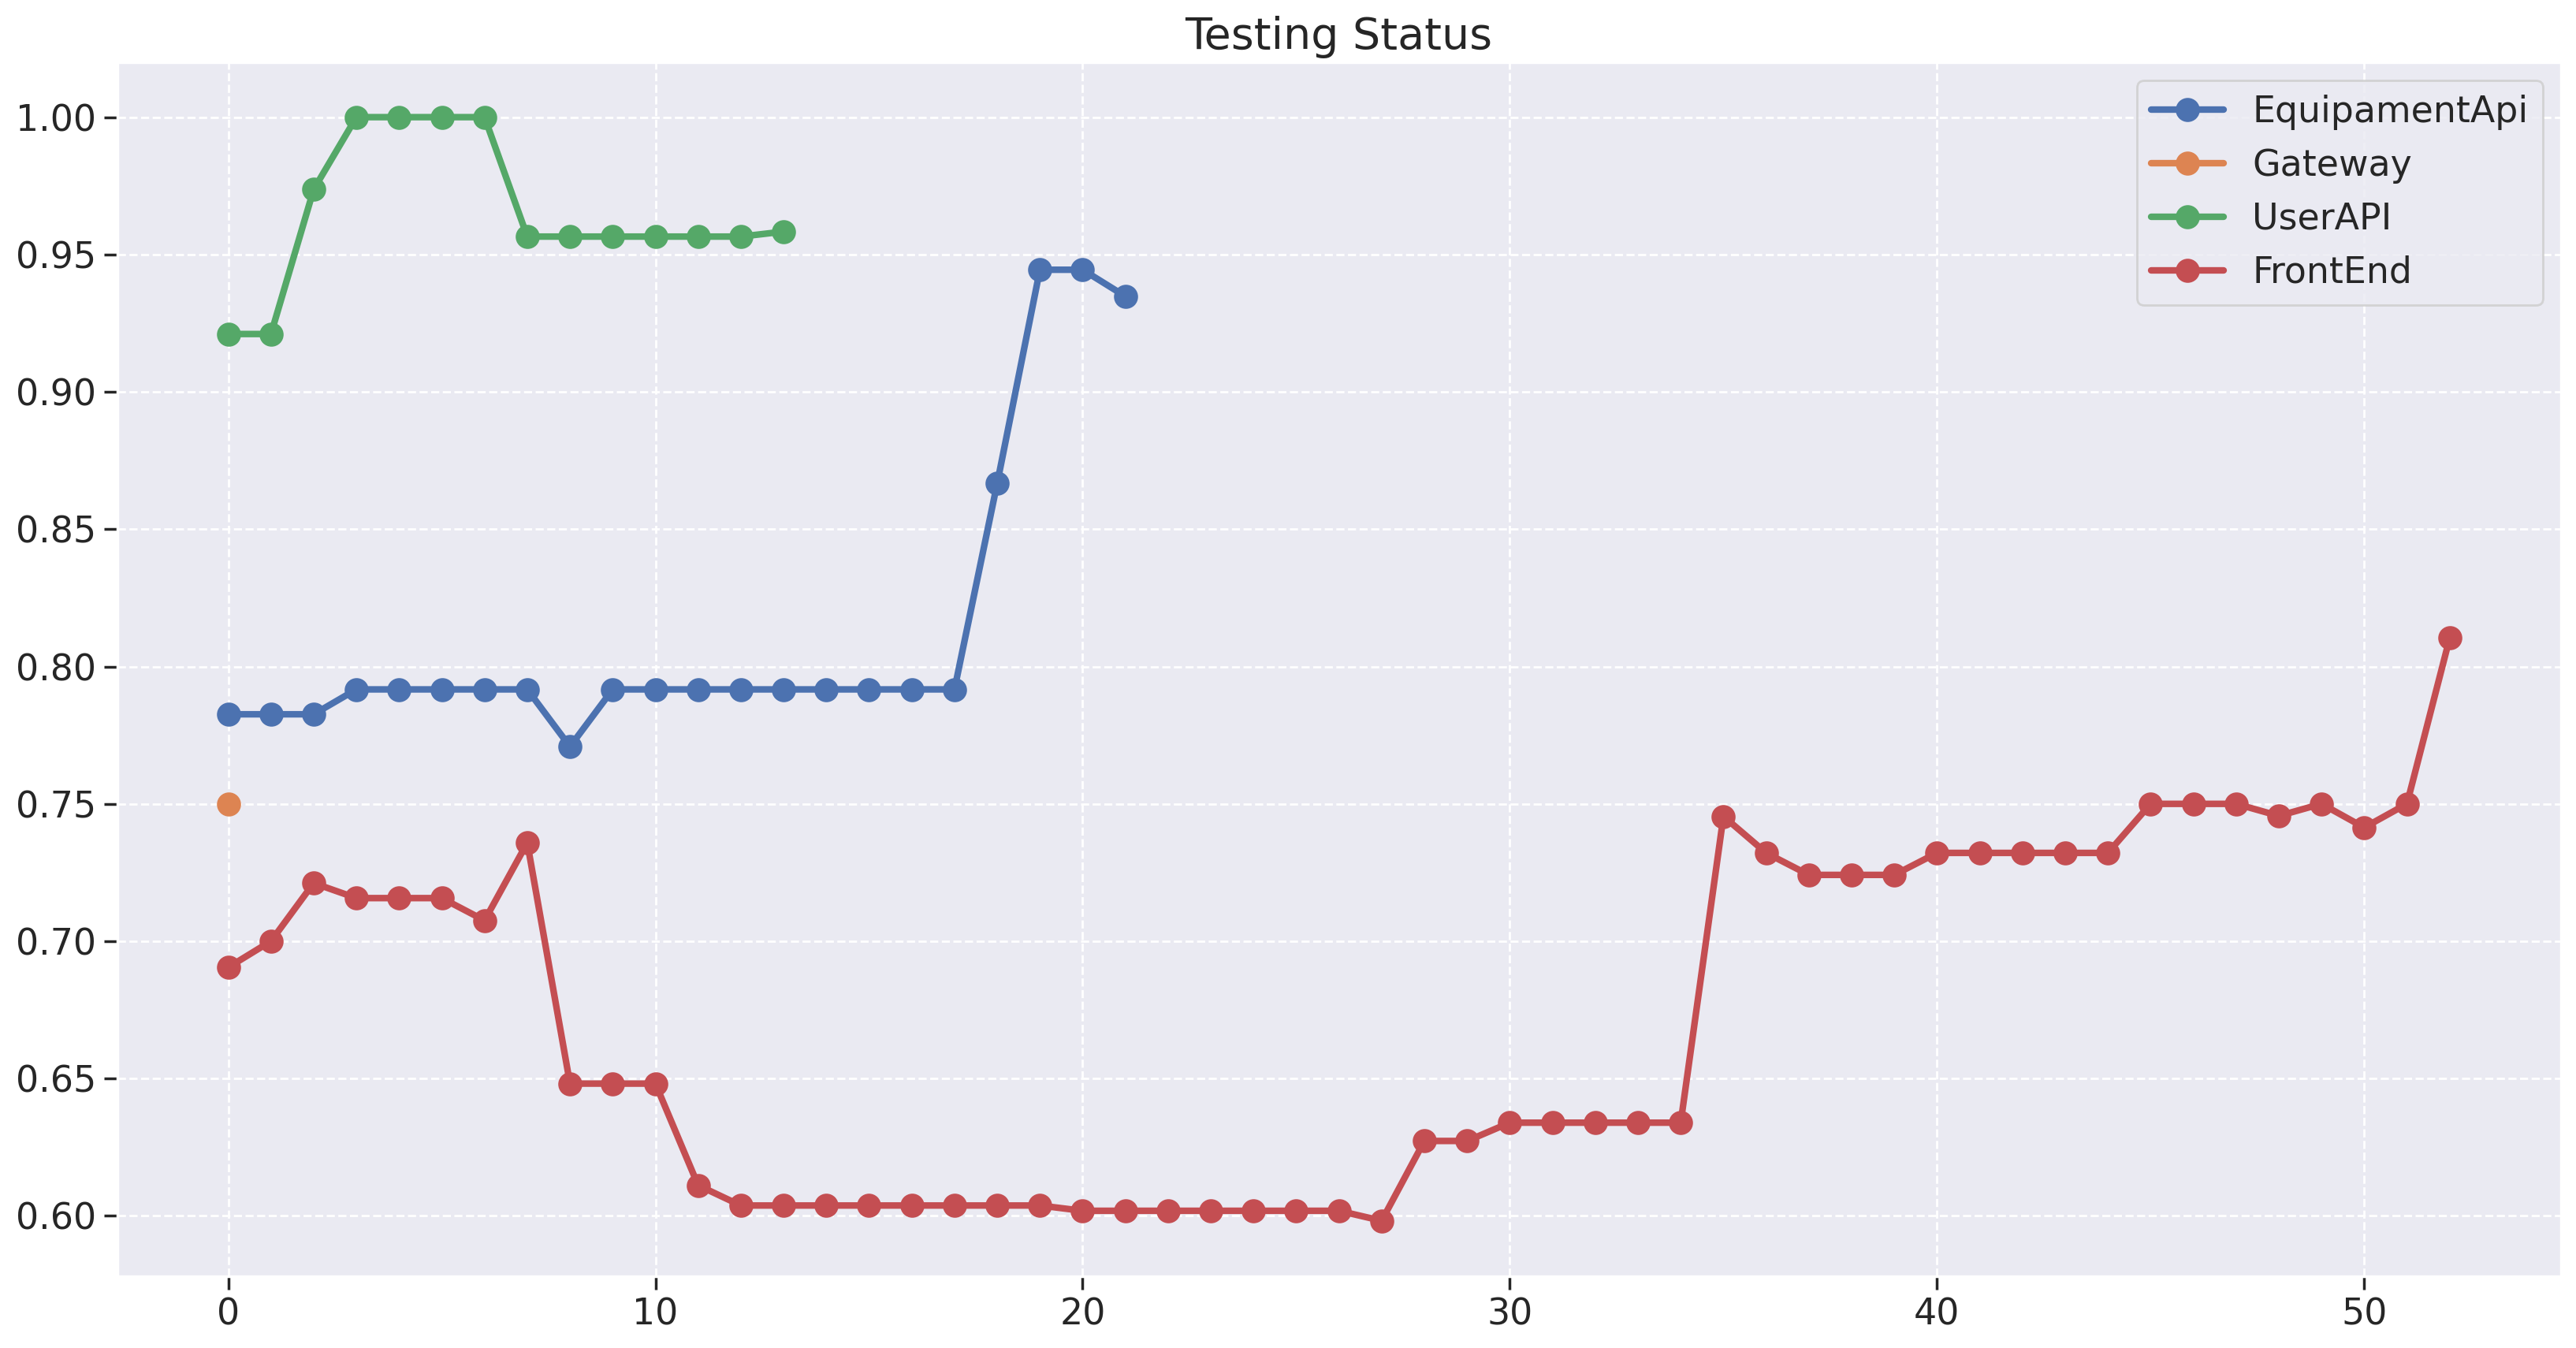

In [26]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [27]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [28]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [29]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

EquipamentApi
Maintainability Stats
    mean    mode  median      std      var      min      max
0.312625 0.31625 0.31625 0.011301 0.000128 0.289667 0.323125
Reliability Stats
    mean     mode   median      std      var      min      max
0.406644 0.395833 0.395833 0.027426 0.000752 0.385417 0.472222


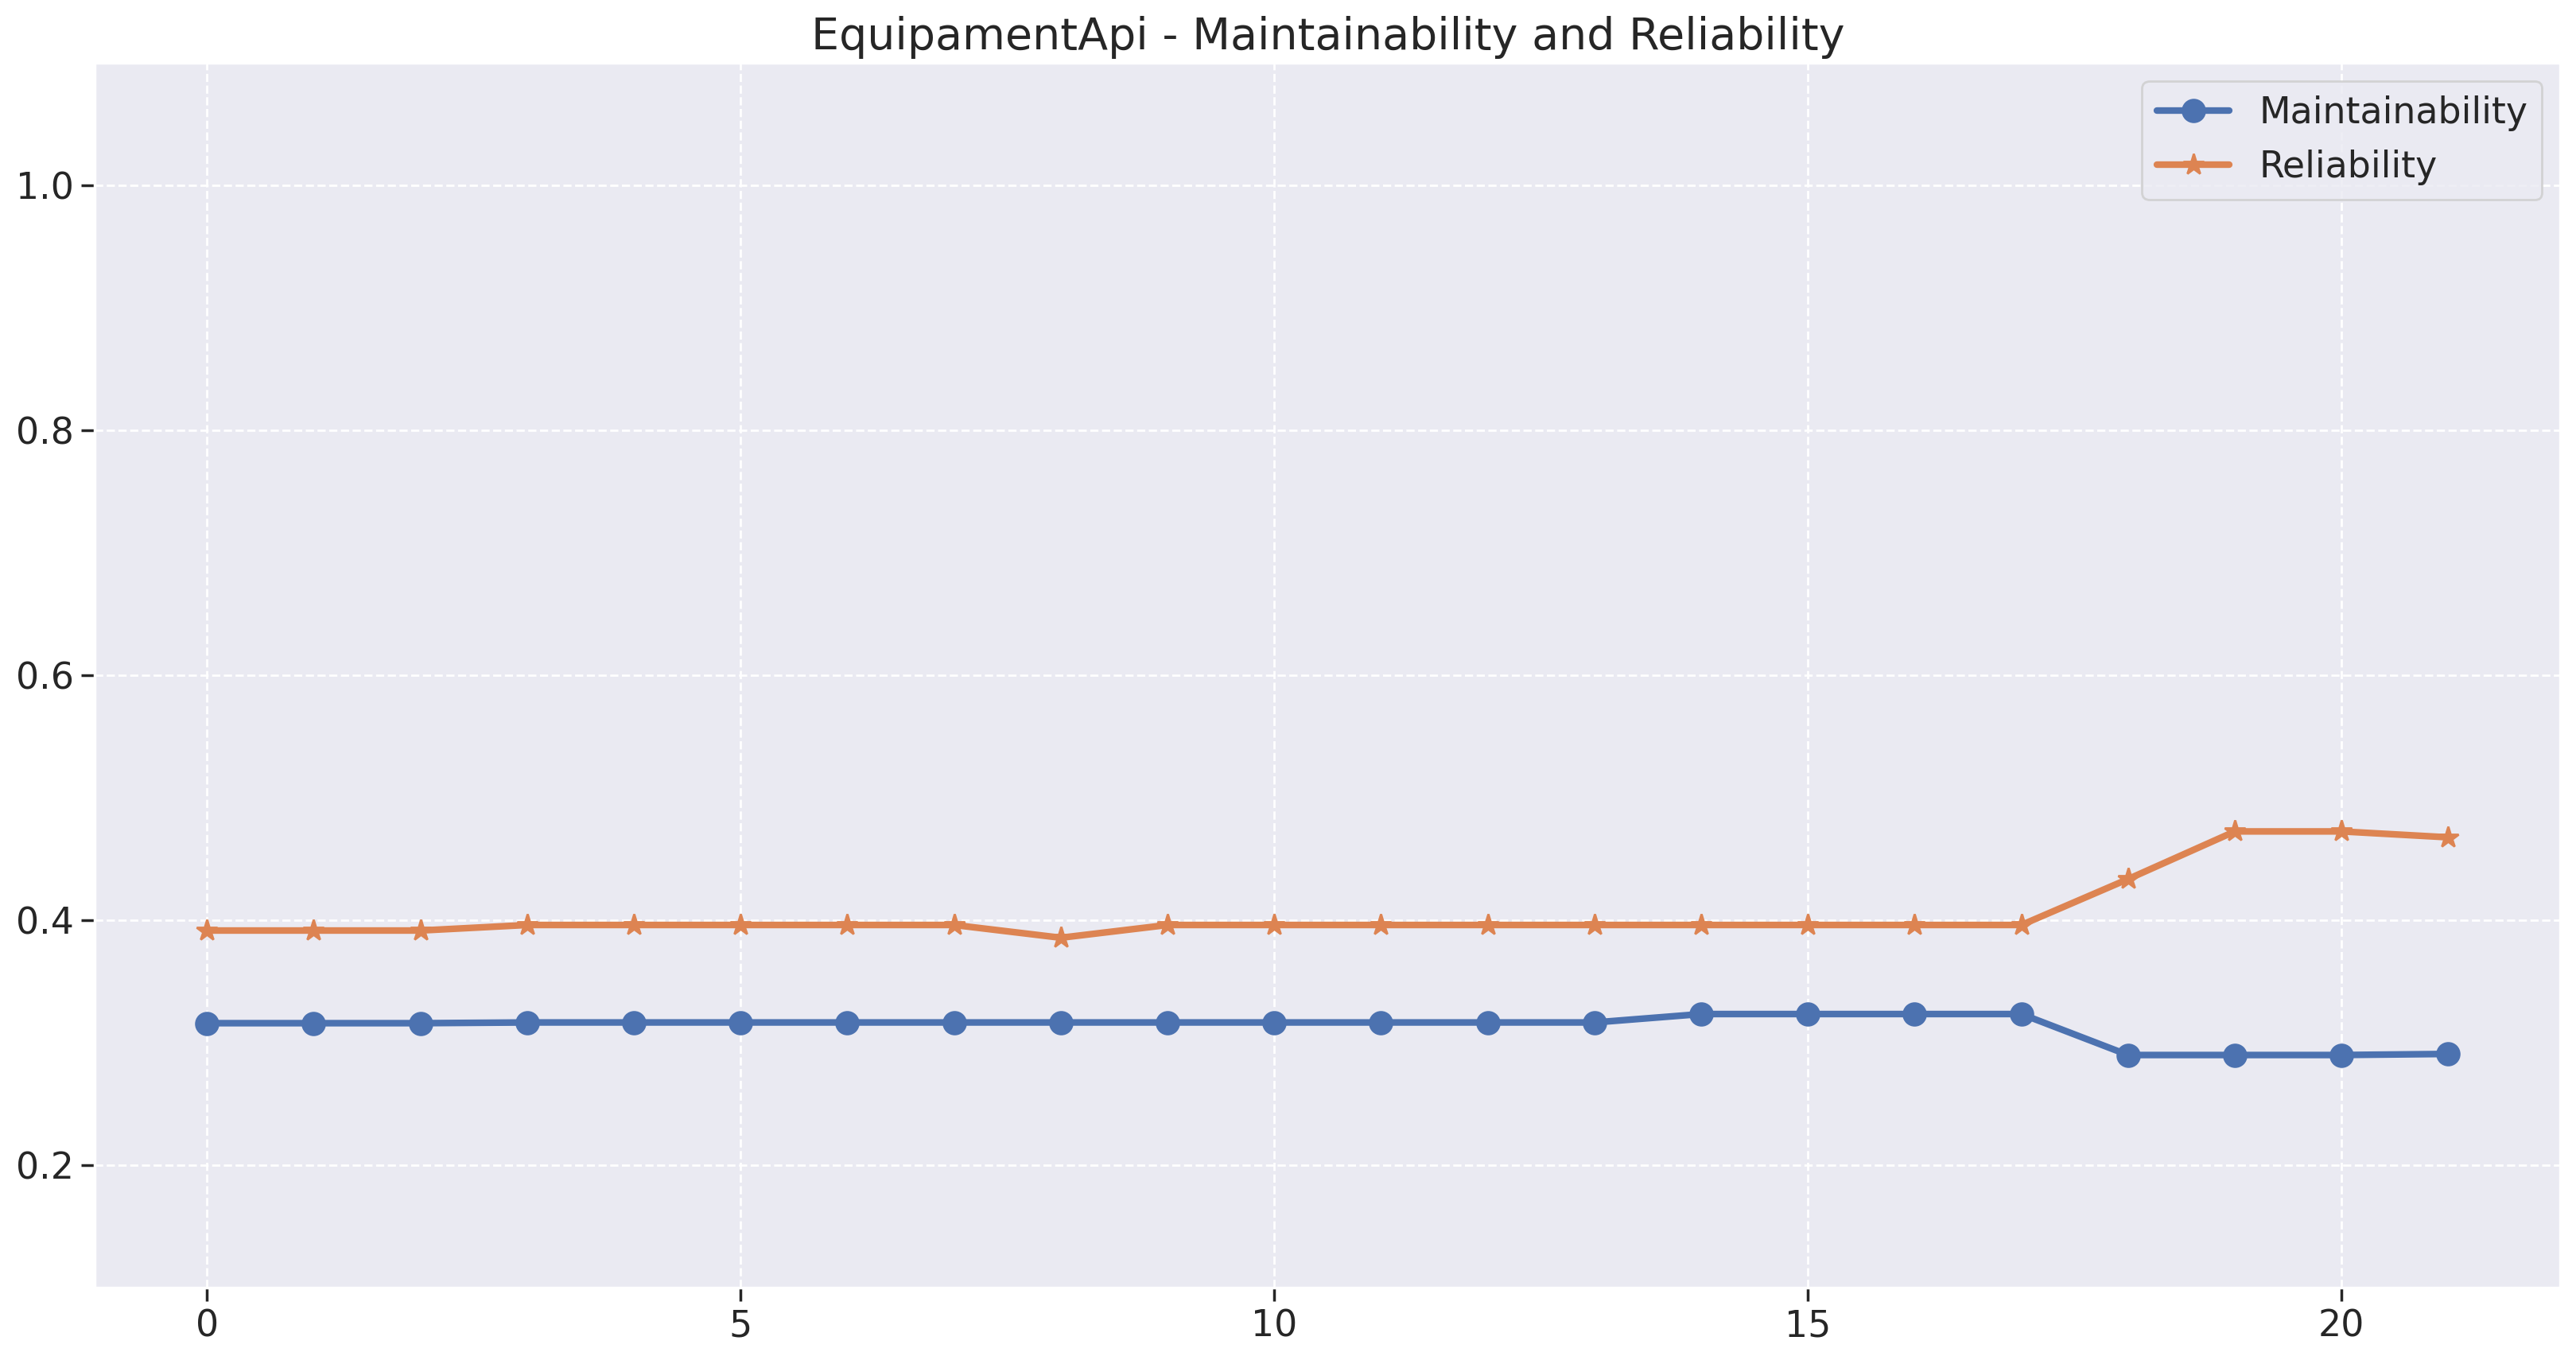

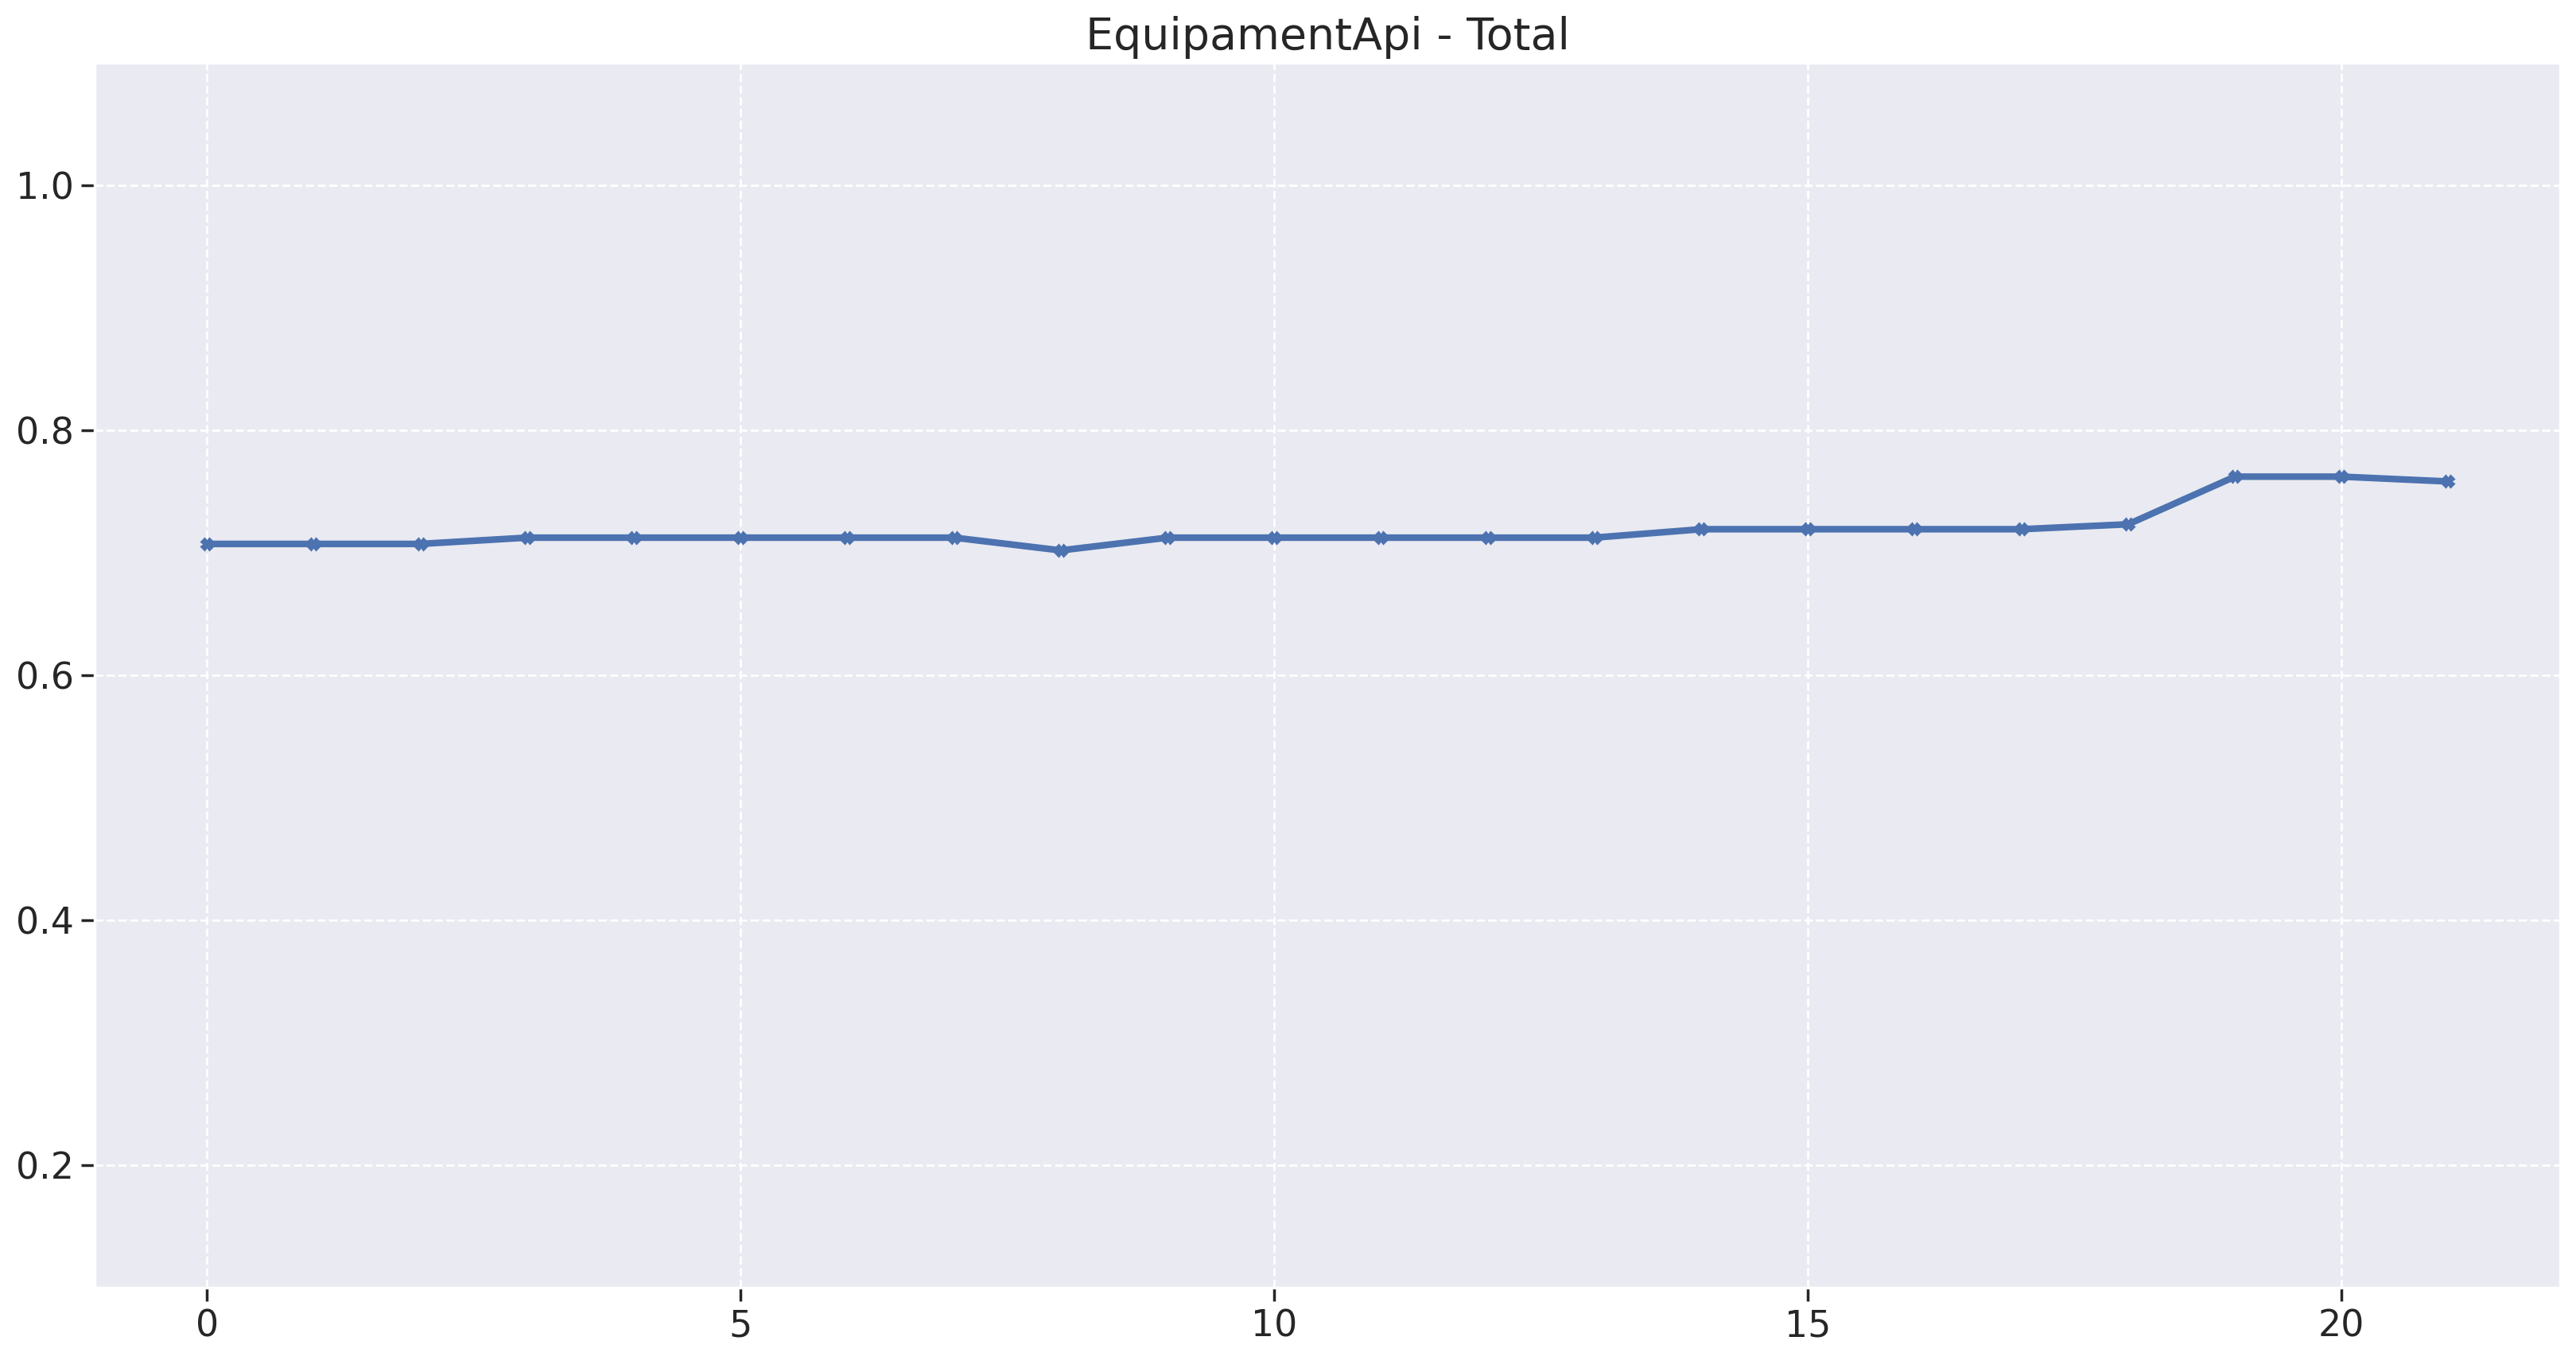

Gateway
Maintainability Stats
 mean  mode  median std var  min  max
 0.33  0.33    0.33 NaN NaN 0.33 0.33
Reliability Stats
 mean  mode  median std var   min   max
0.375 0.375   0.375 NaN NaN 0.375 0.375


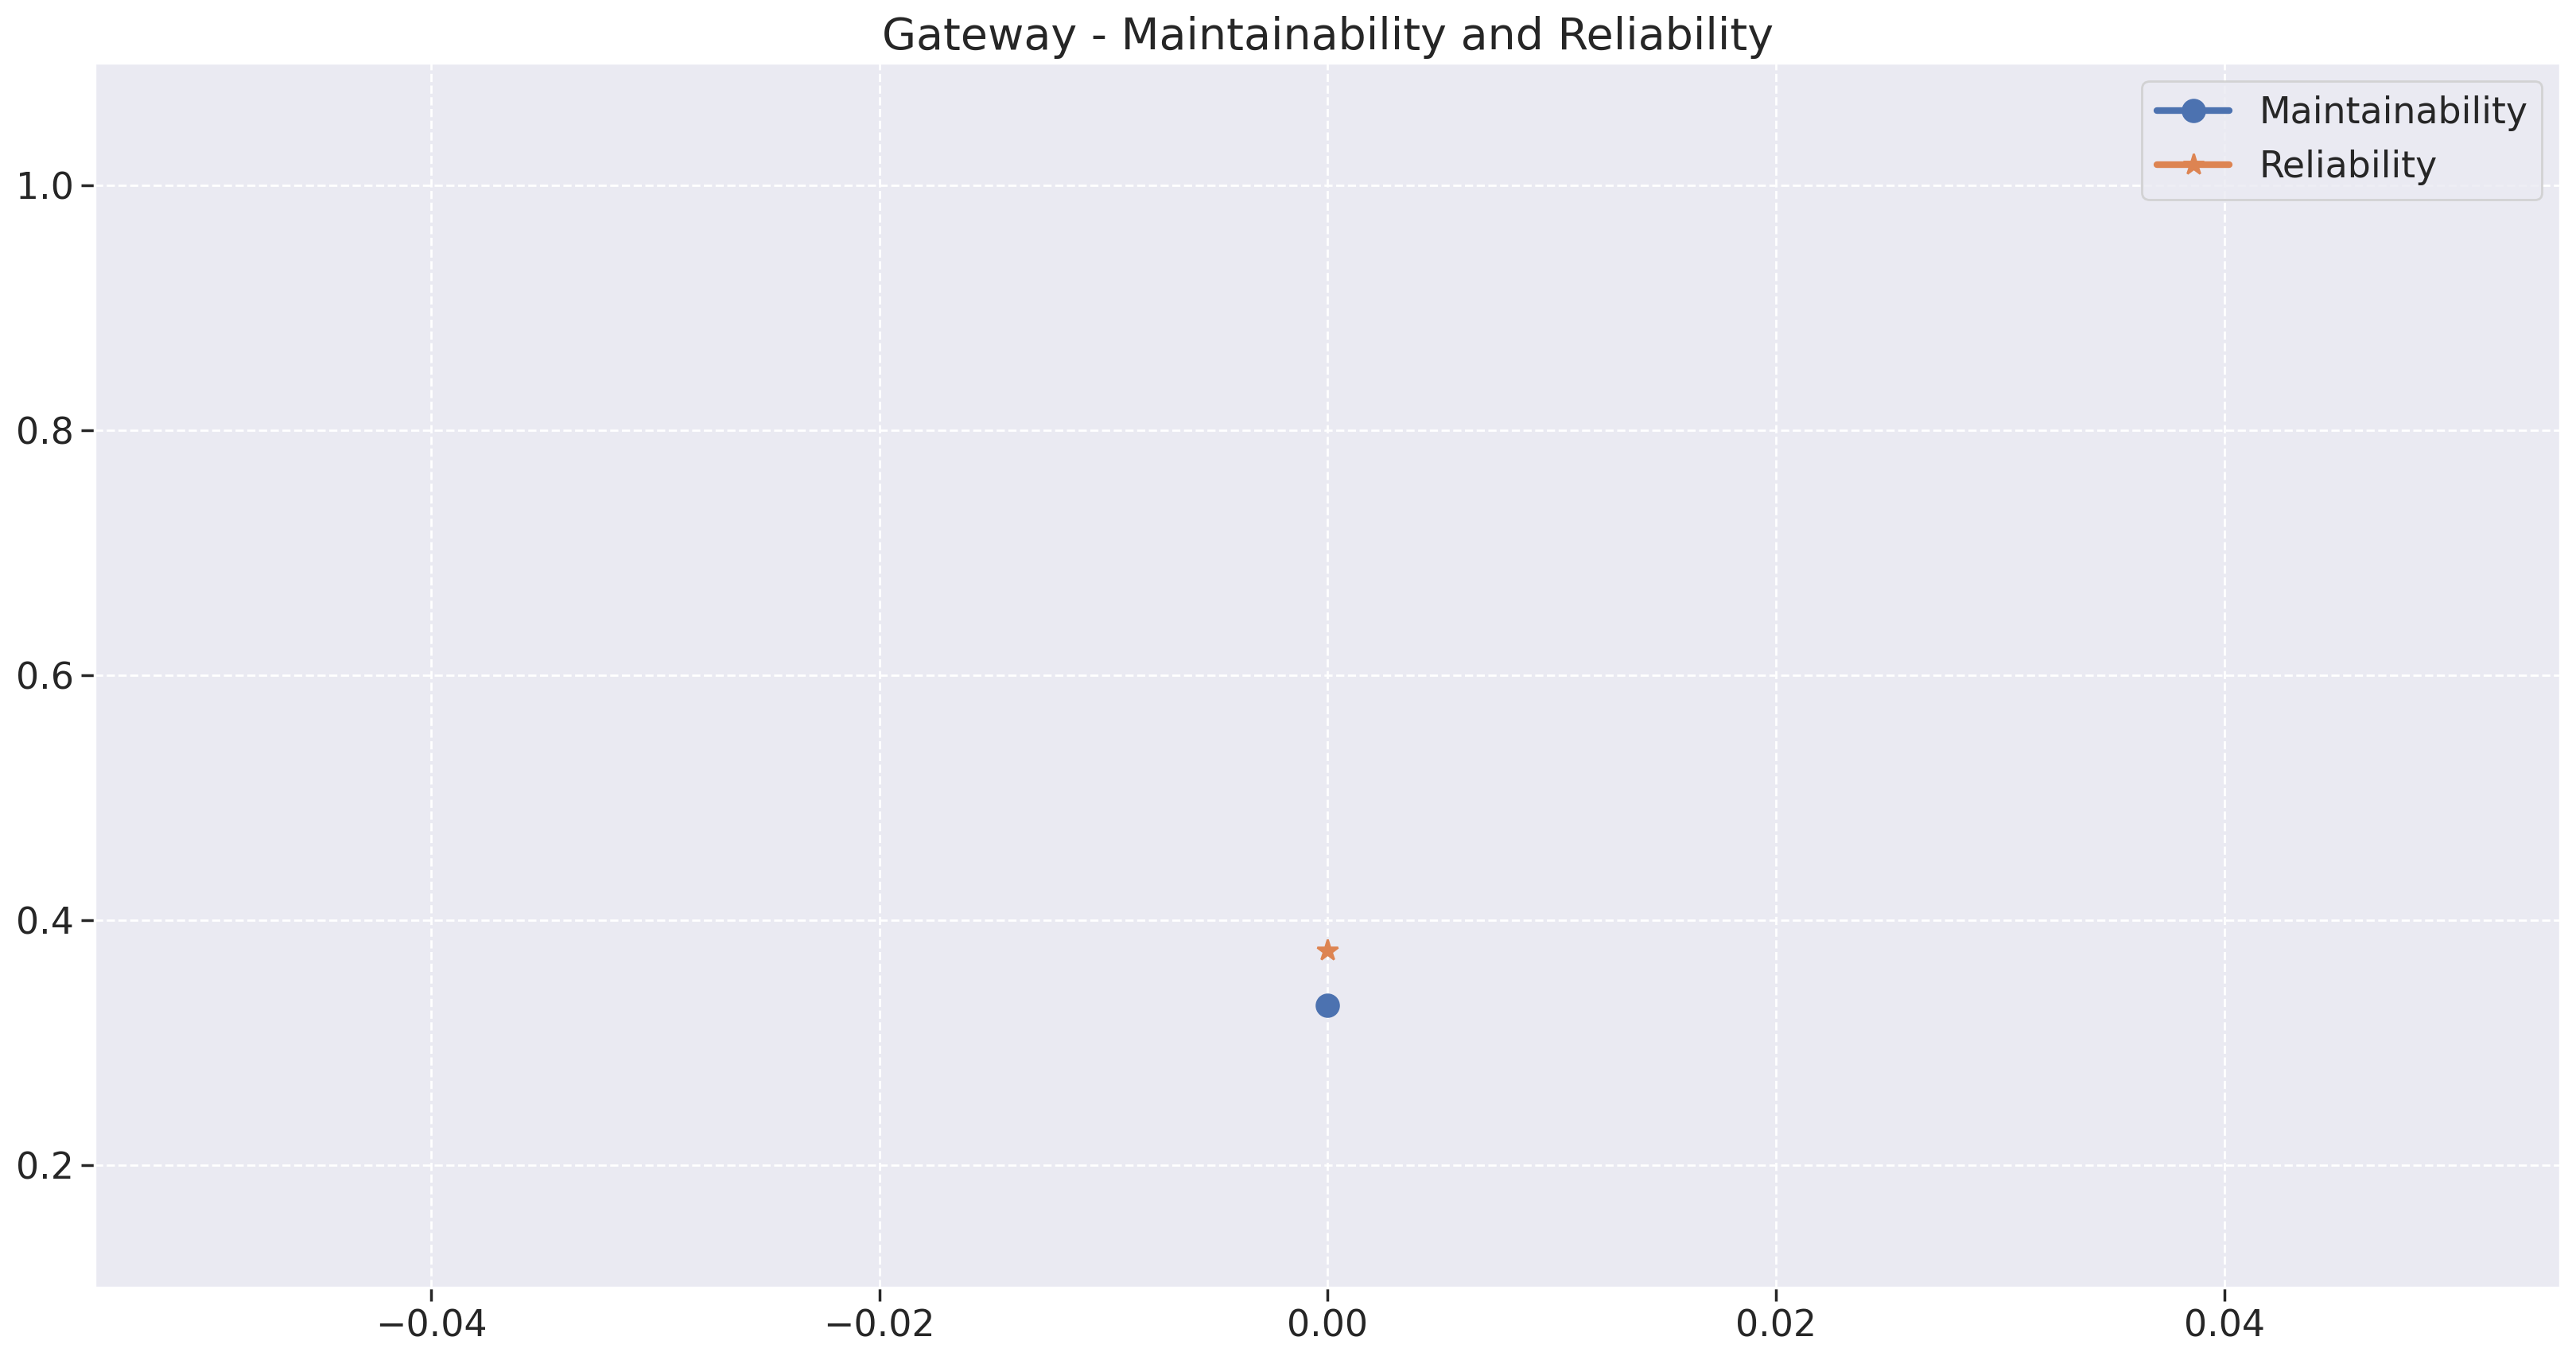

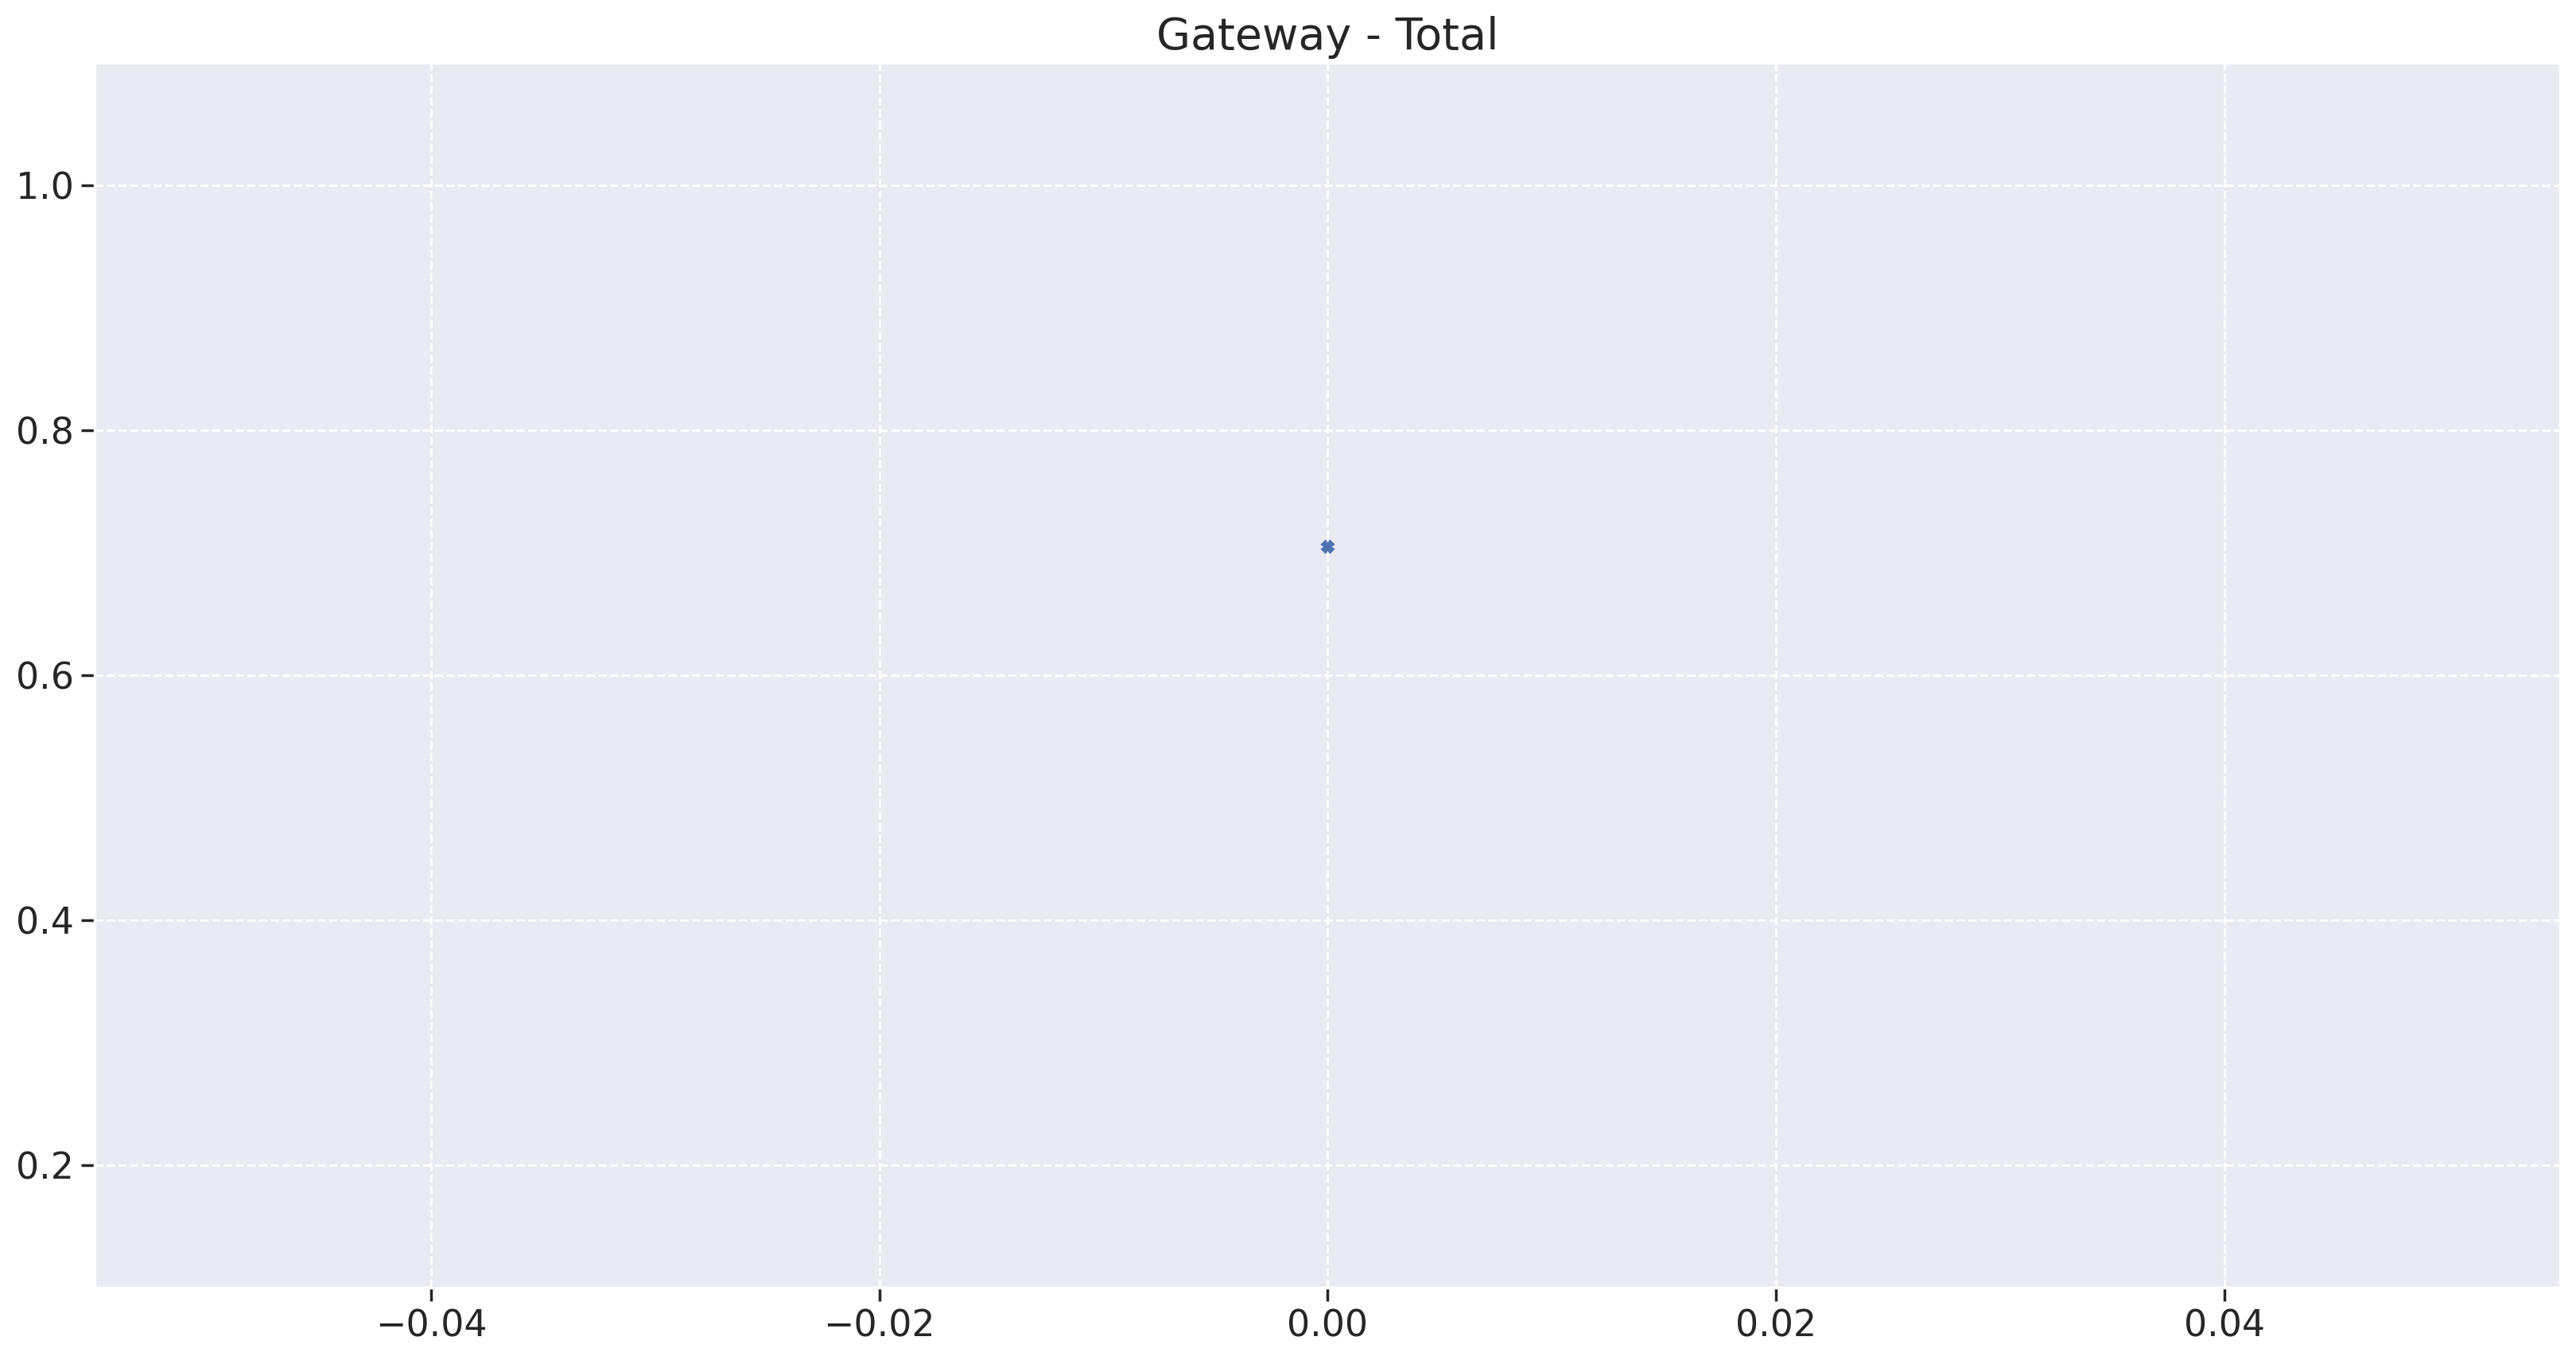

UserAPI
Maintainability Stats
    mean     mode   median      std      var      min     max
0.314354 0.312632 0.315326 0.001567 0.000002 0.312632 0.31625
0.314354 0.315652 0.315326 0.001567 0.000002 0.312632 0.31625
Reliability Stats
    mean     mode   median      std      var      min  max
0.482616 0.478261 0.478261 0.013383 0.000179 0.460526  0.5


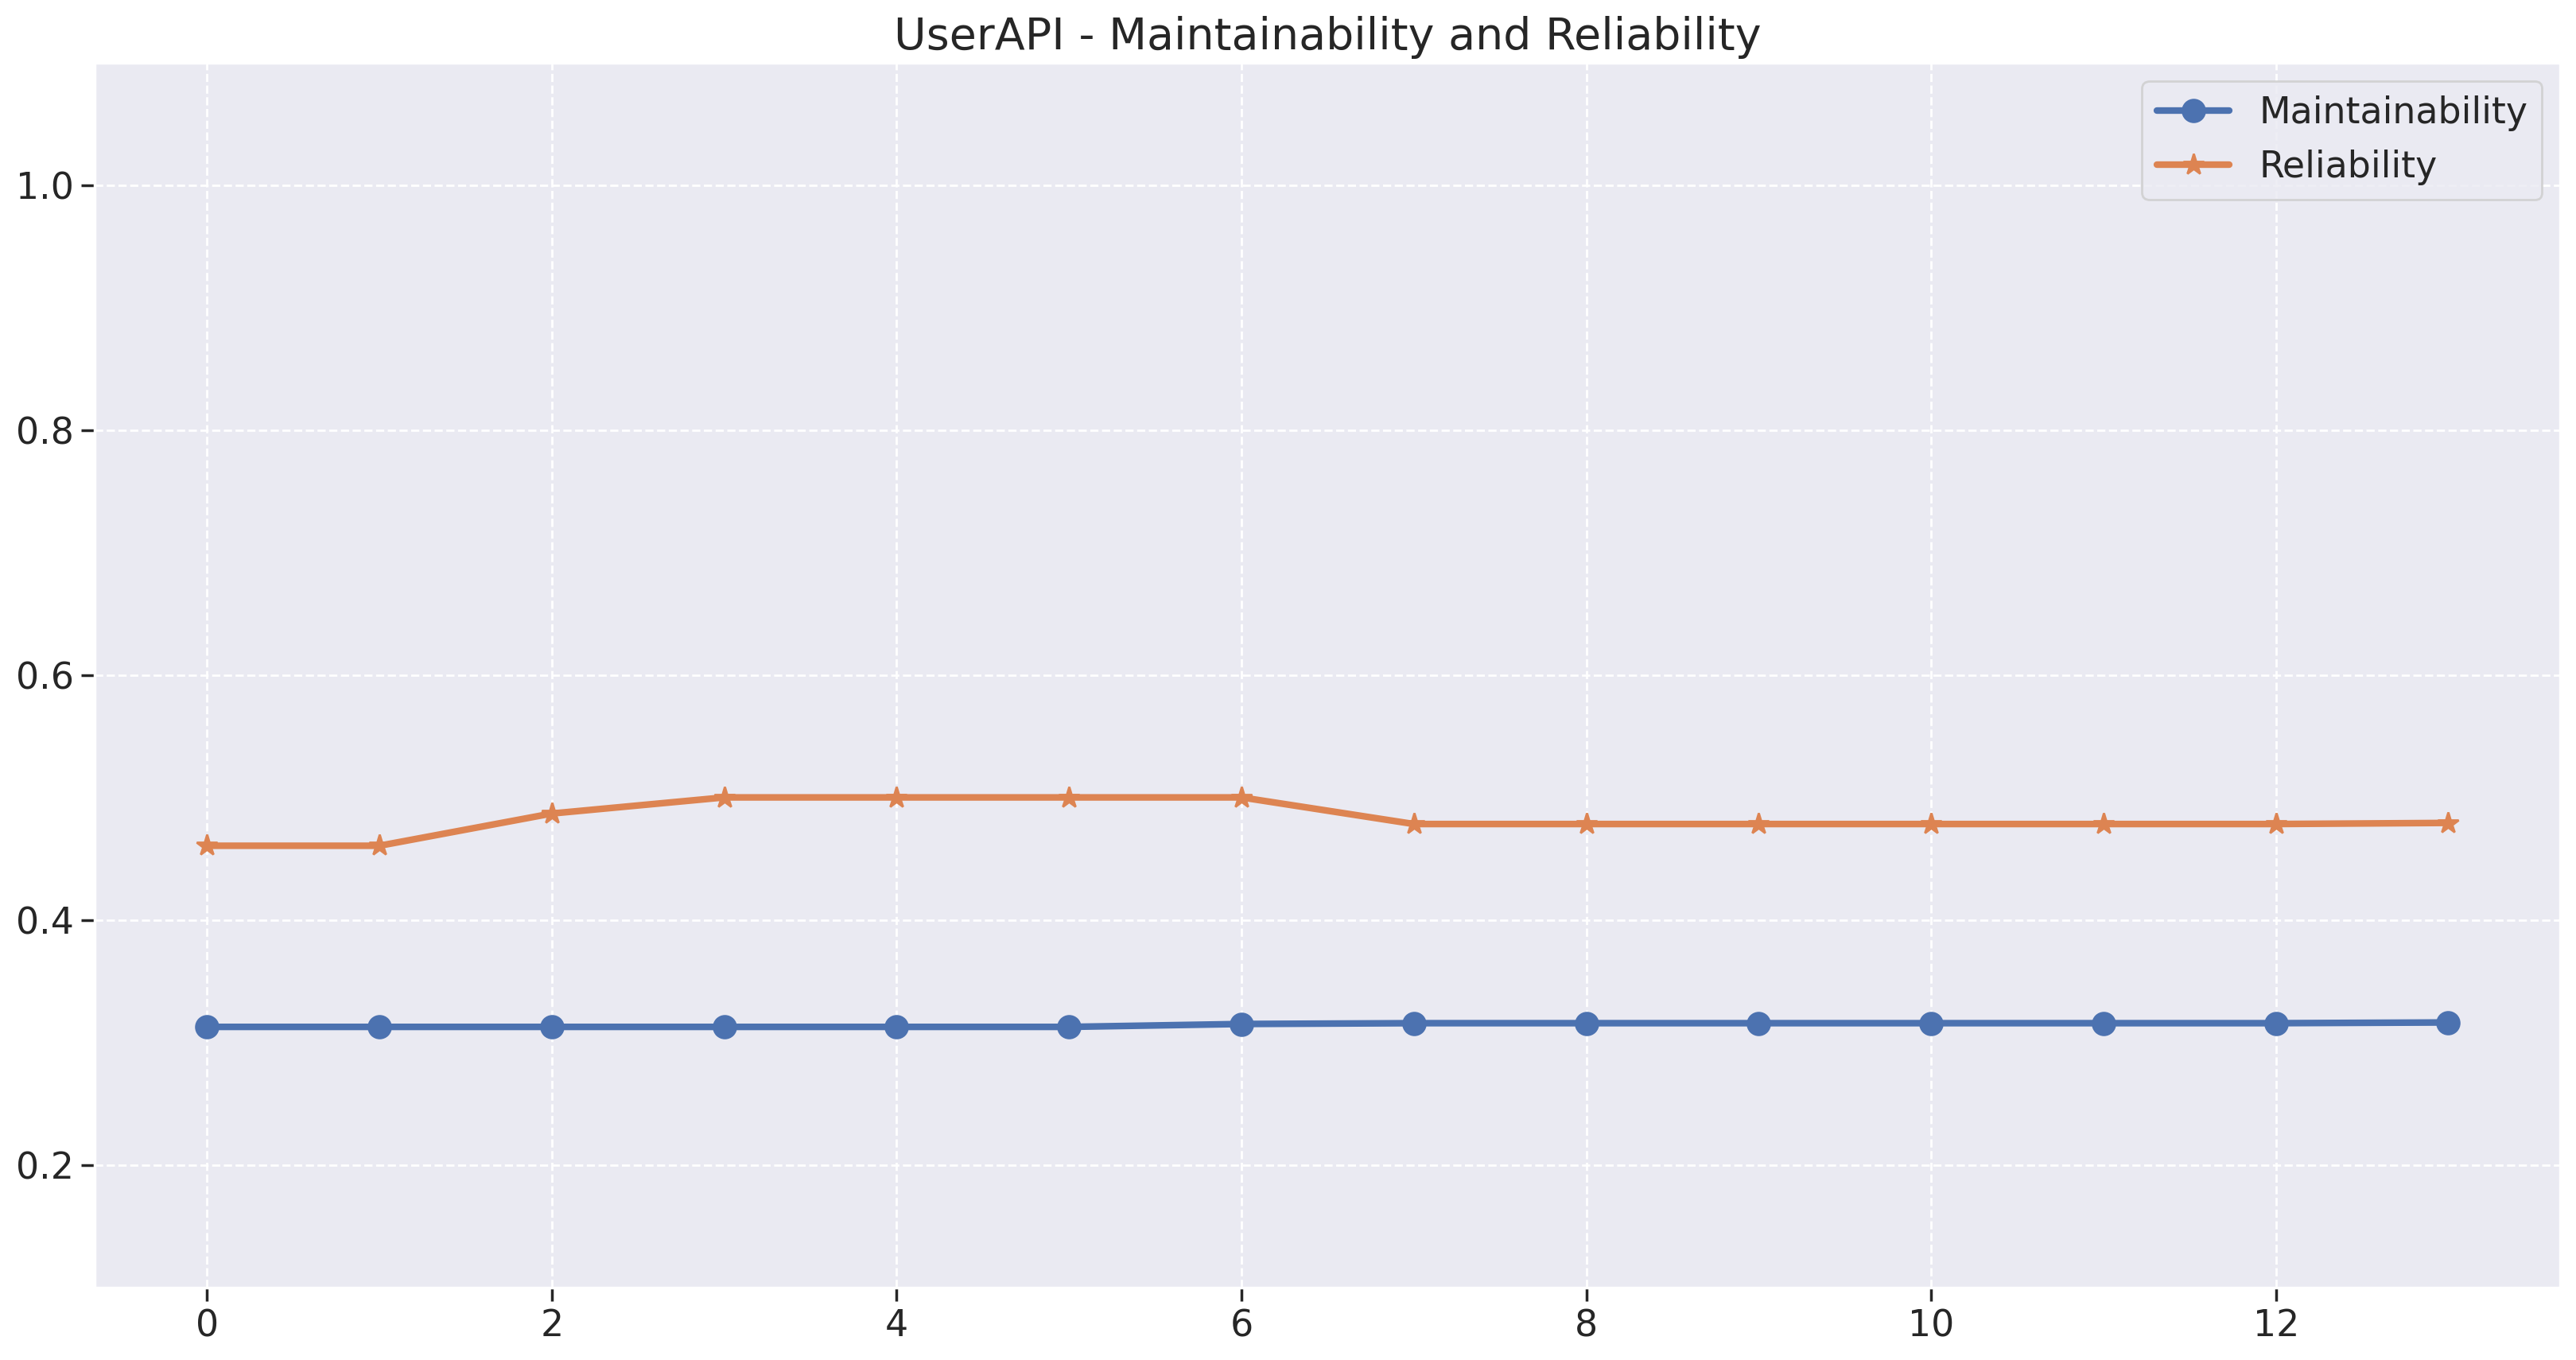

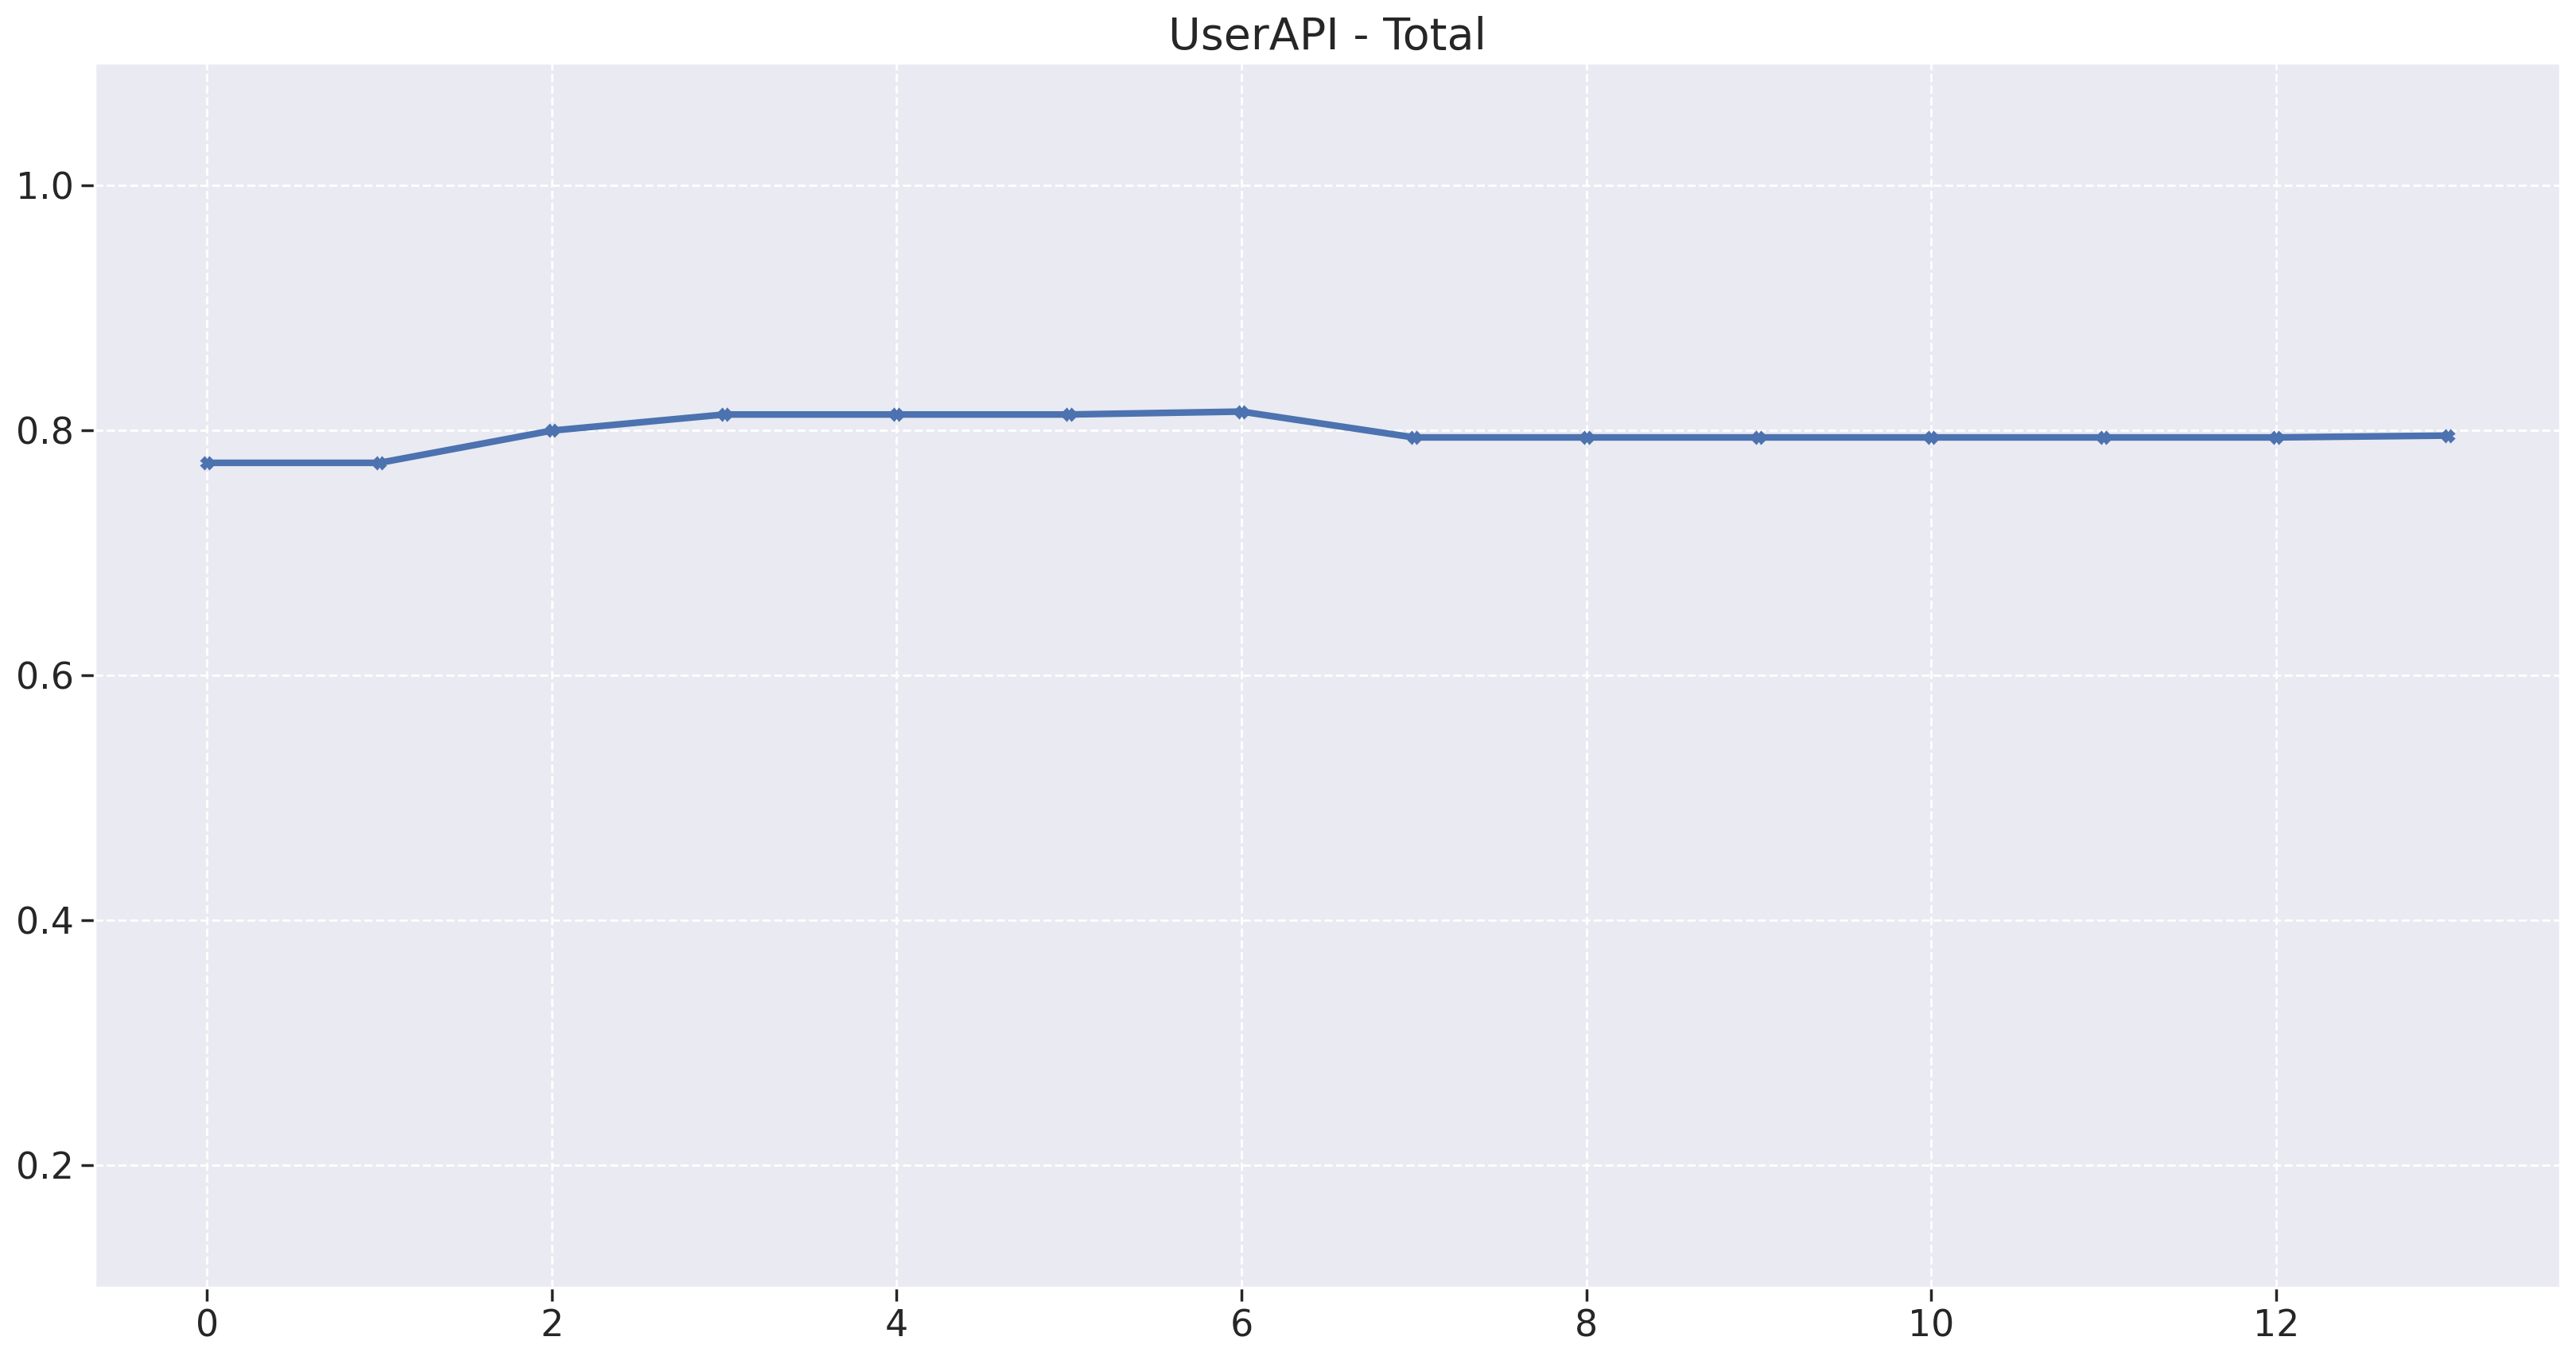

FrontEnd
Maintainability Stats
    mean    mode  median      std     var      min      max
0.283185 0.28875   0.285 0.006292 0.00004 0.271944 0.291696
Reliability Stats
    mean     mode   median      std      var      min      max
0.336616 0.301887 0.324074 0.031268 0.000978 0.299107 0.405172


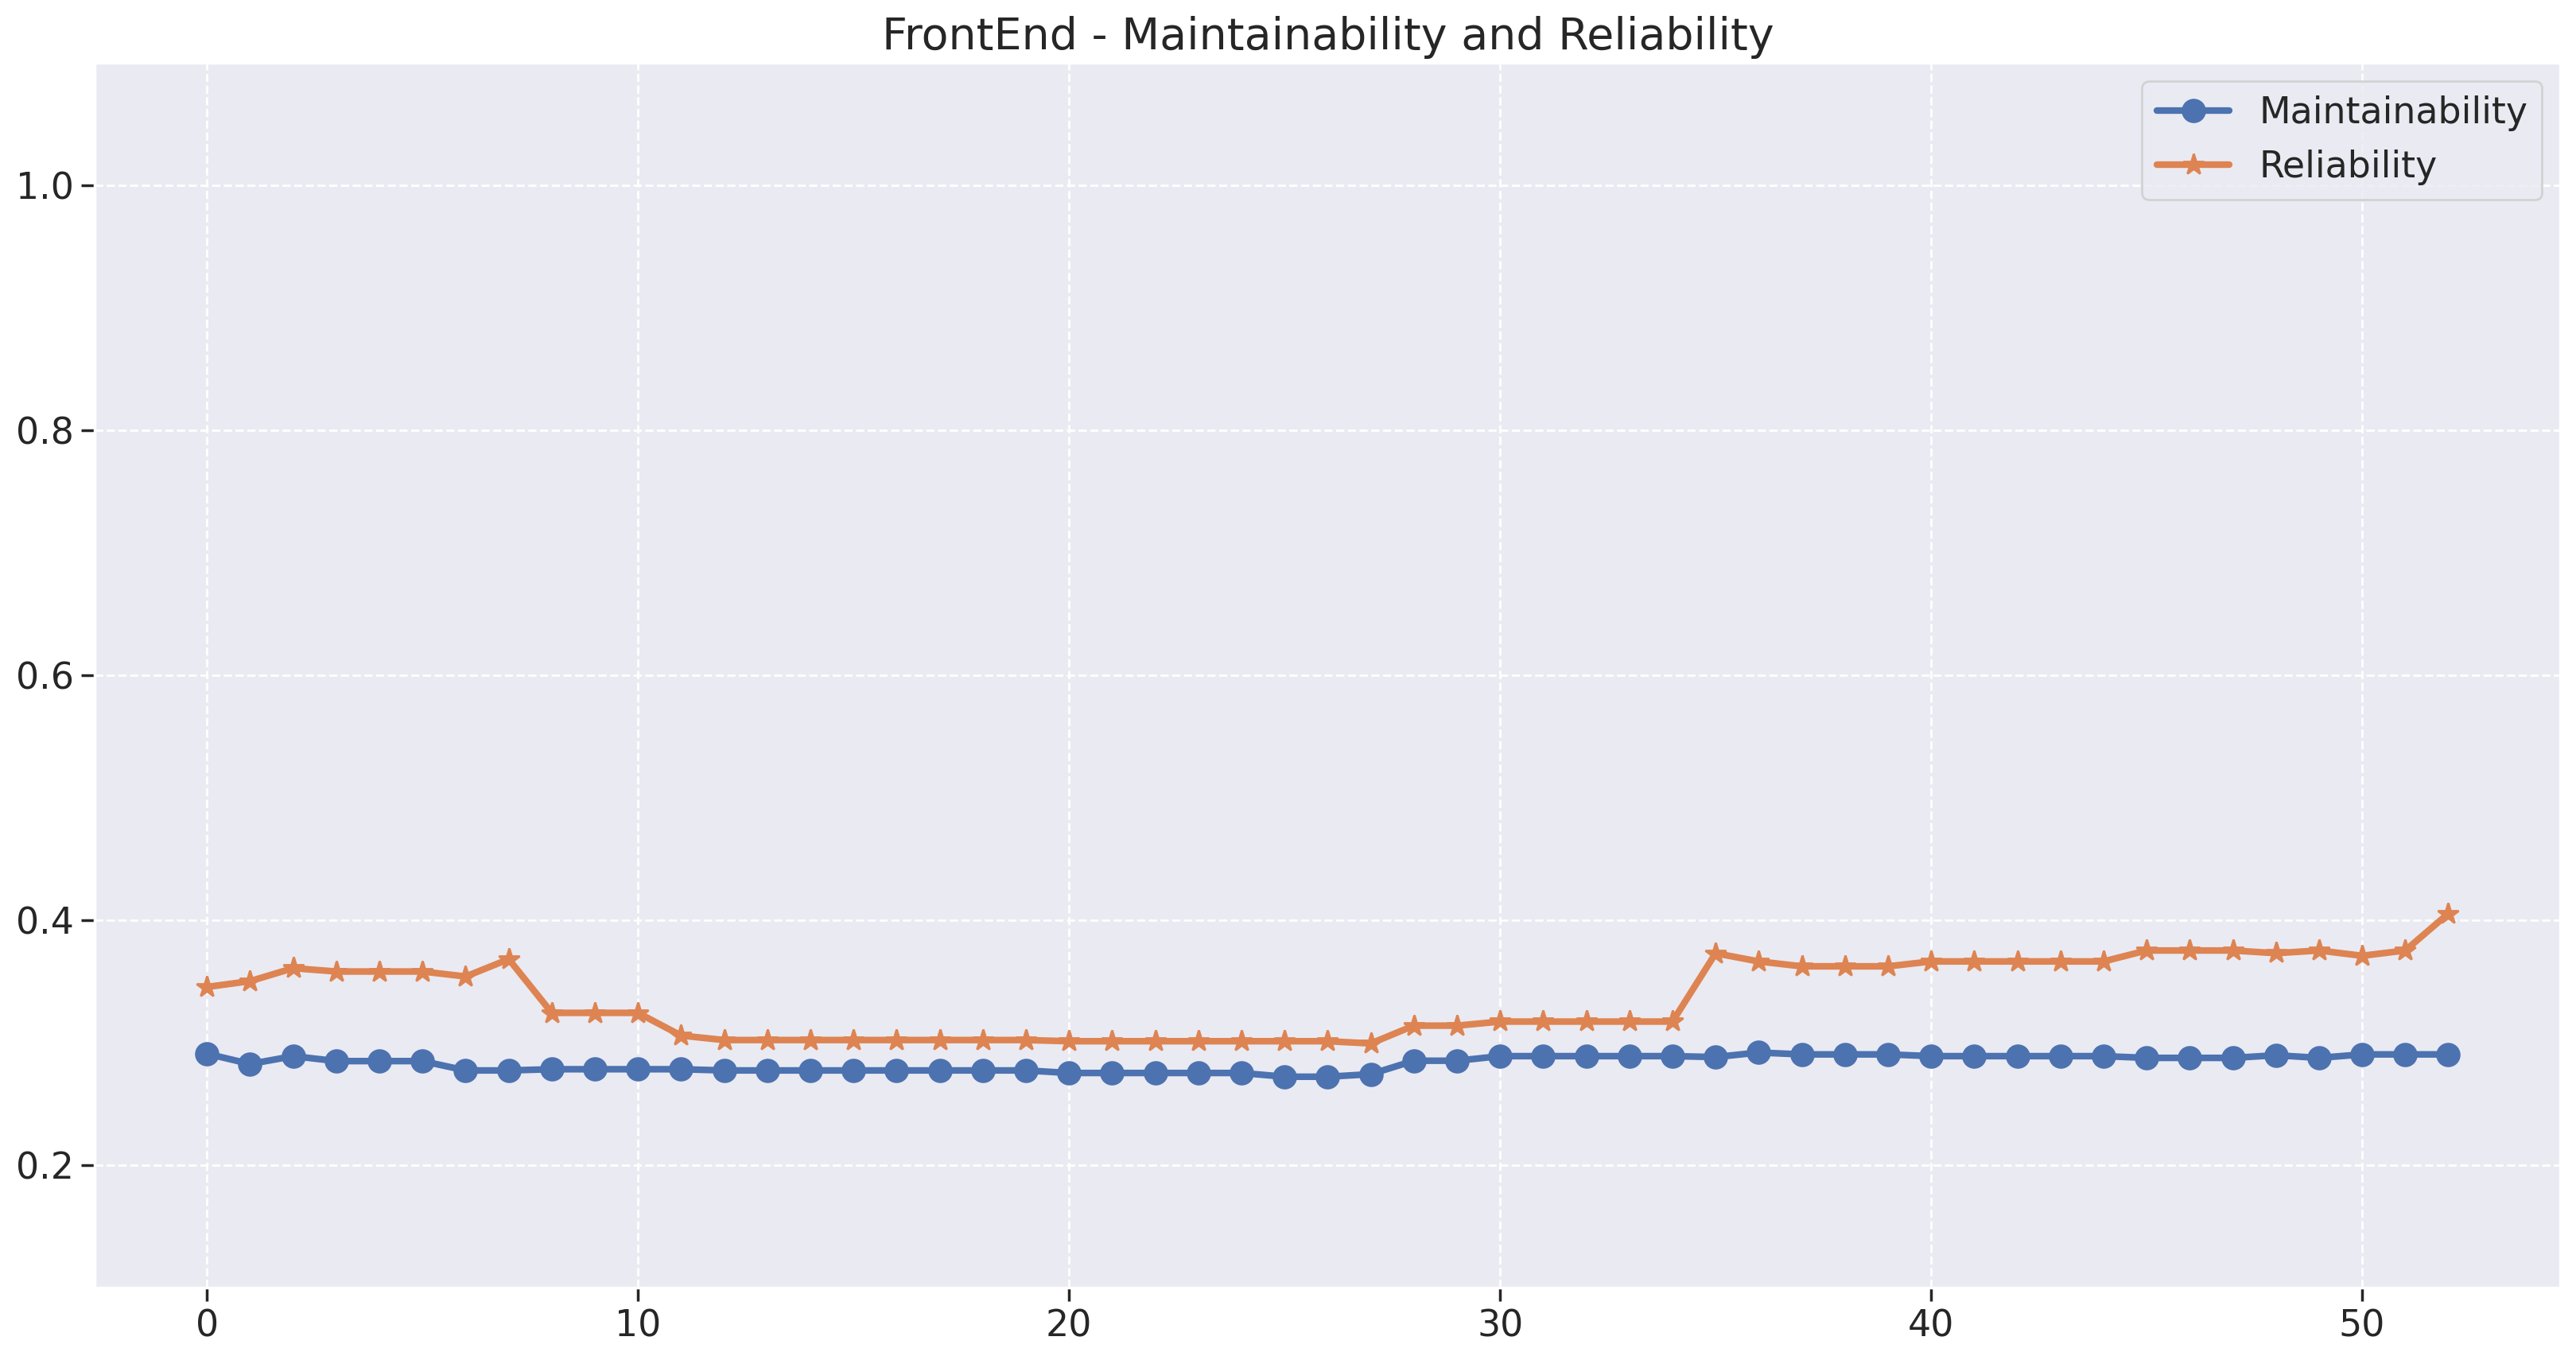

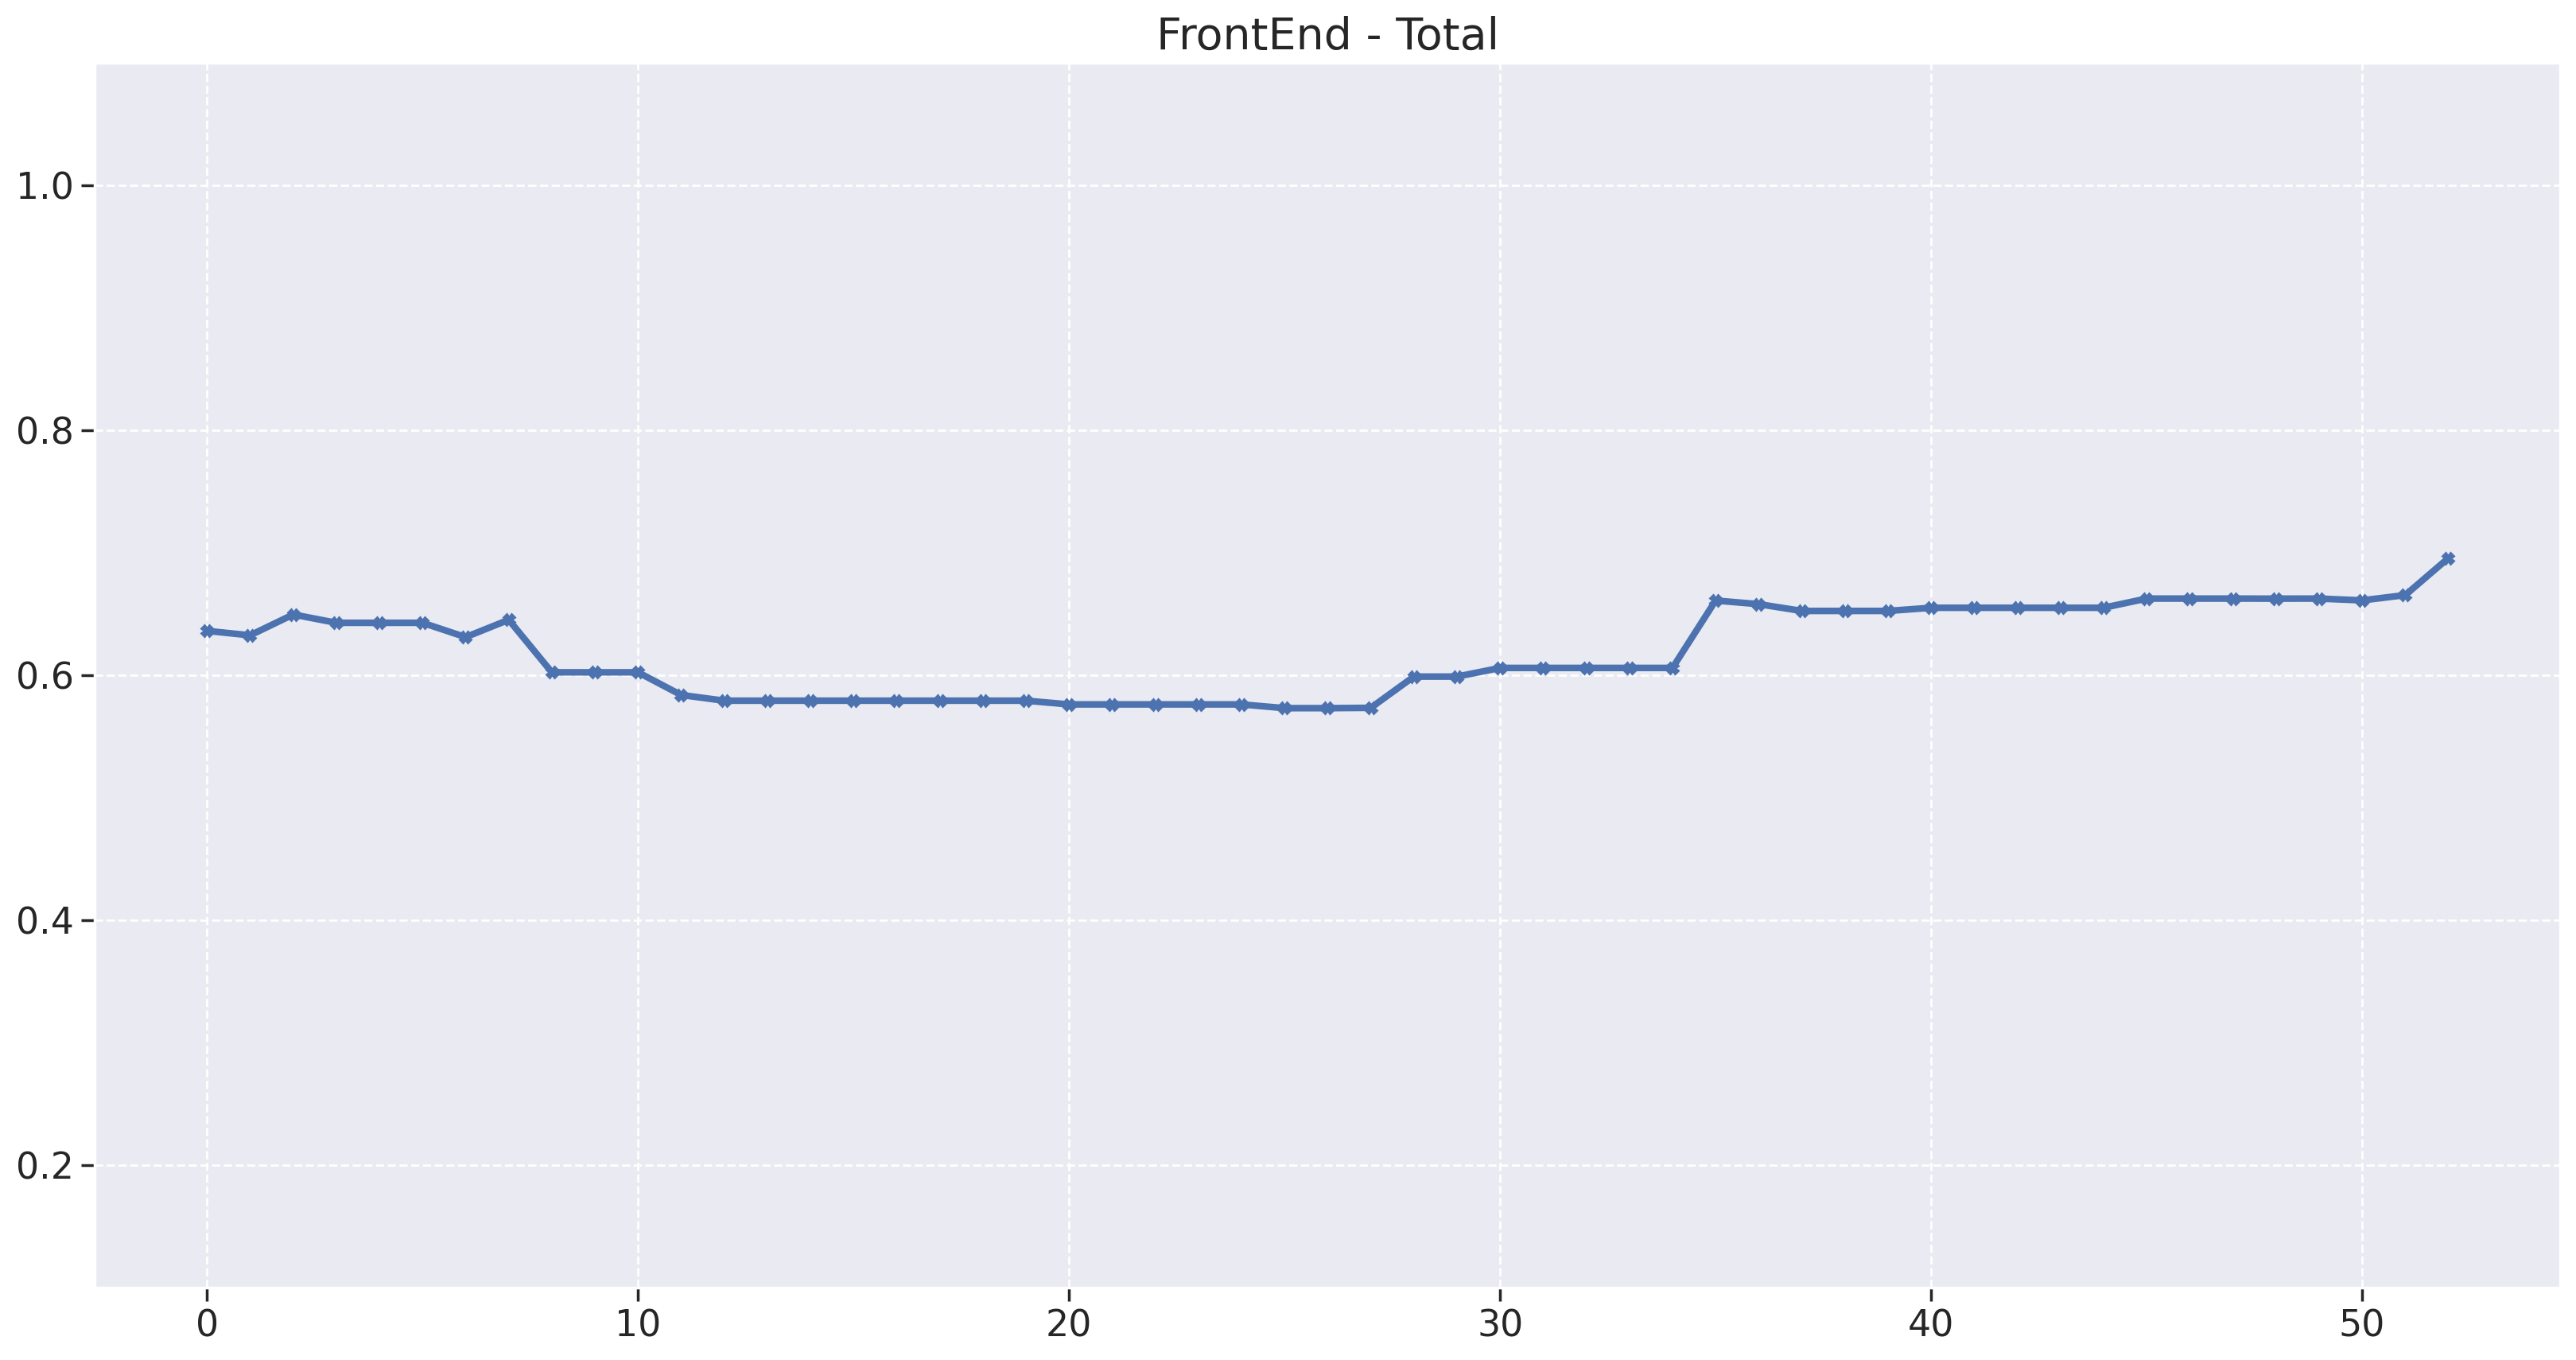

In [30]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

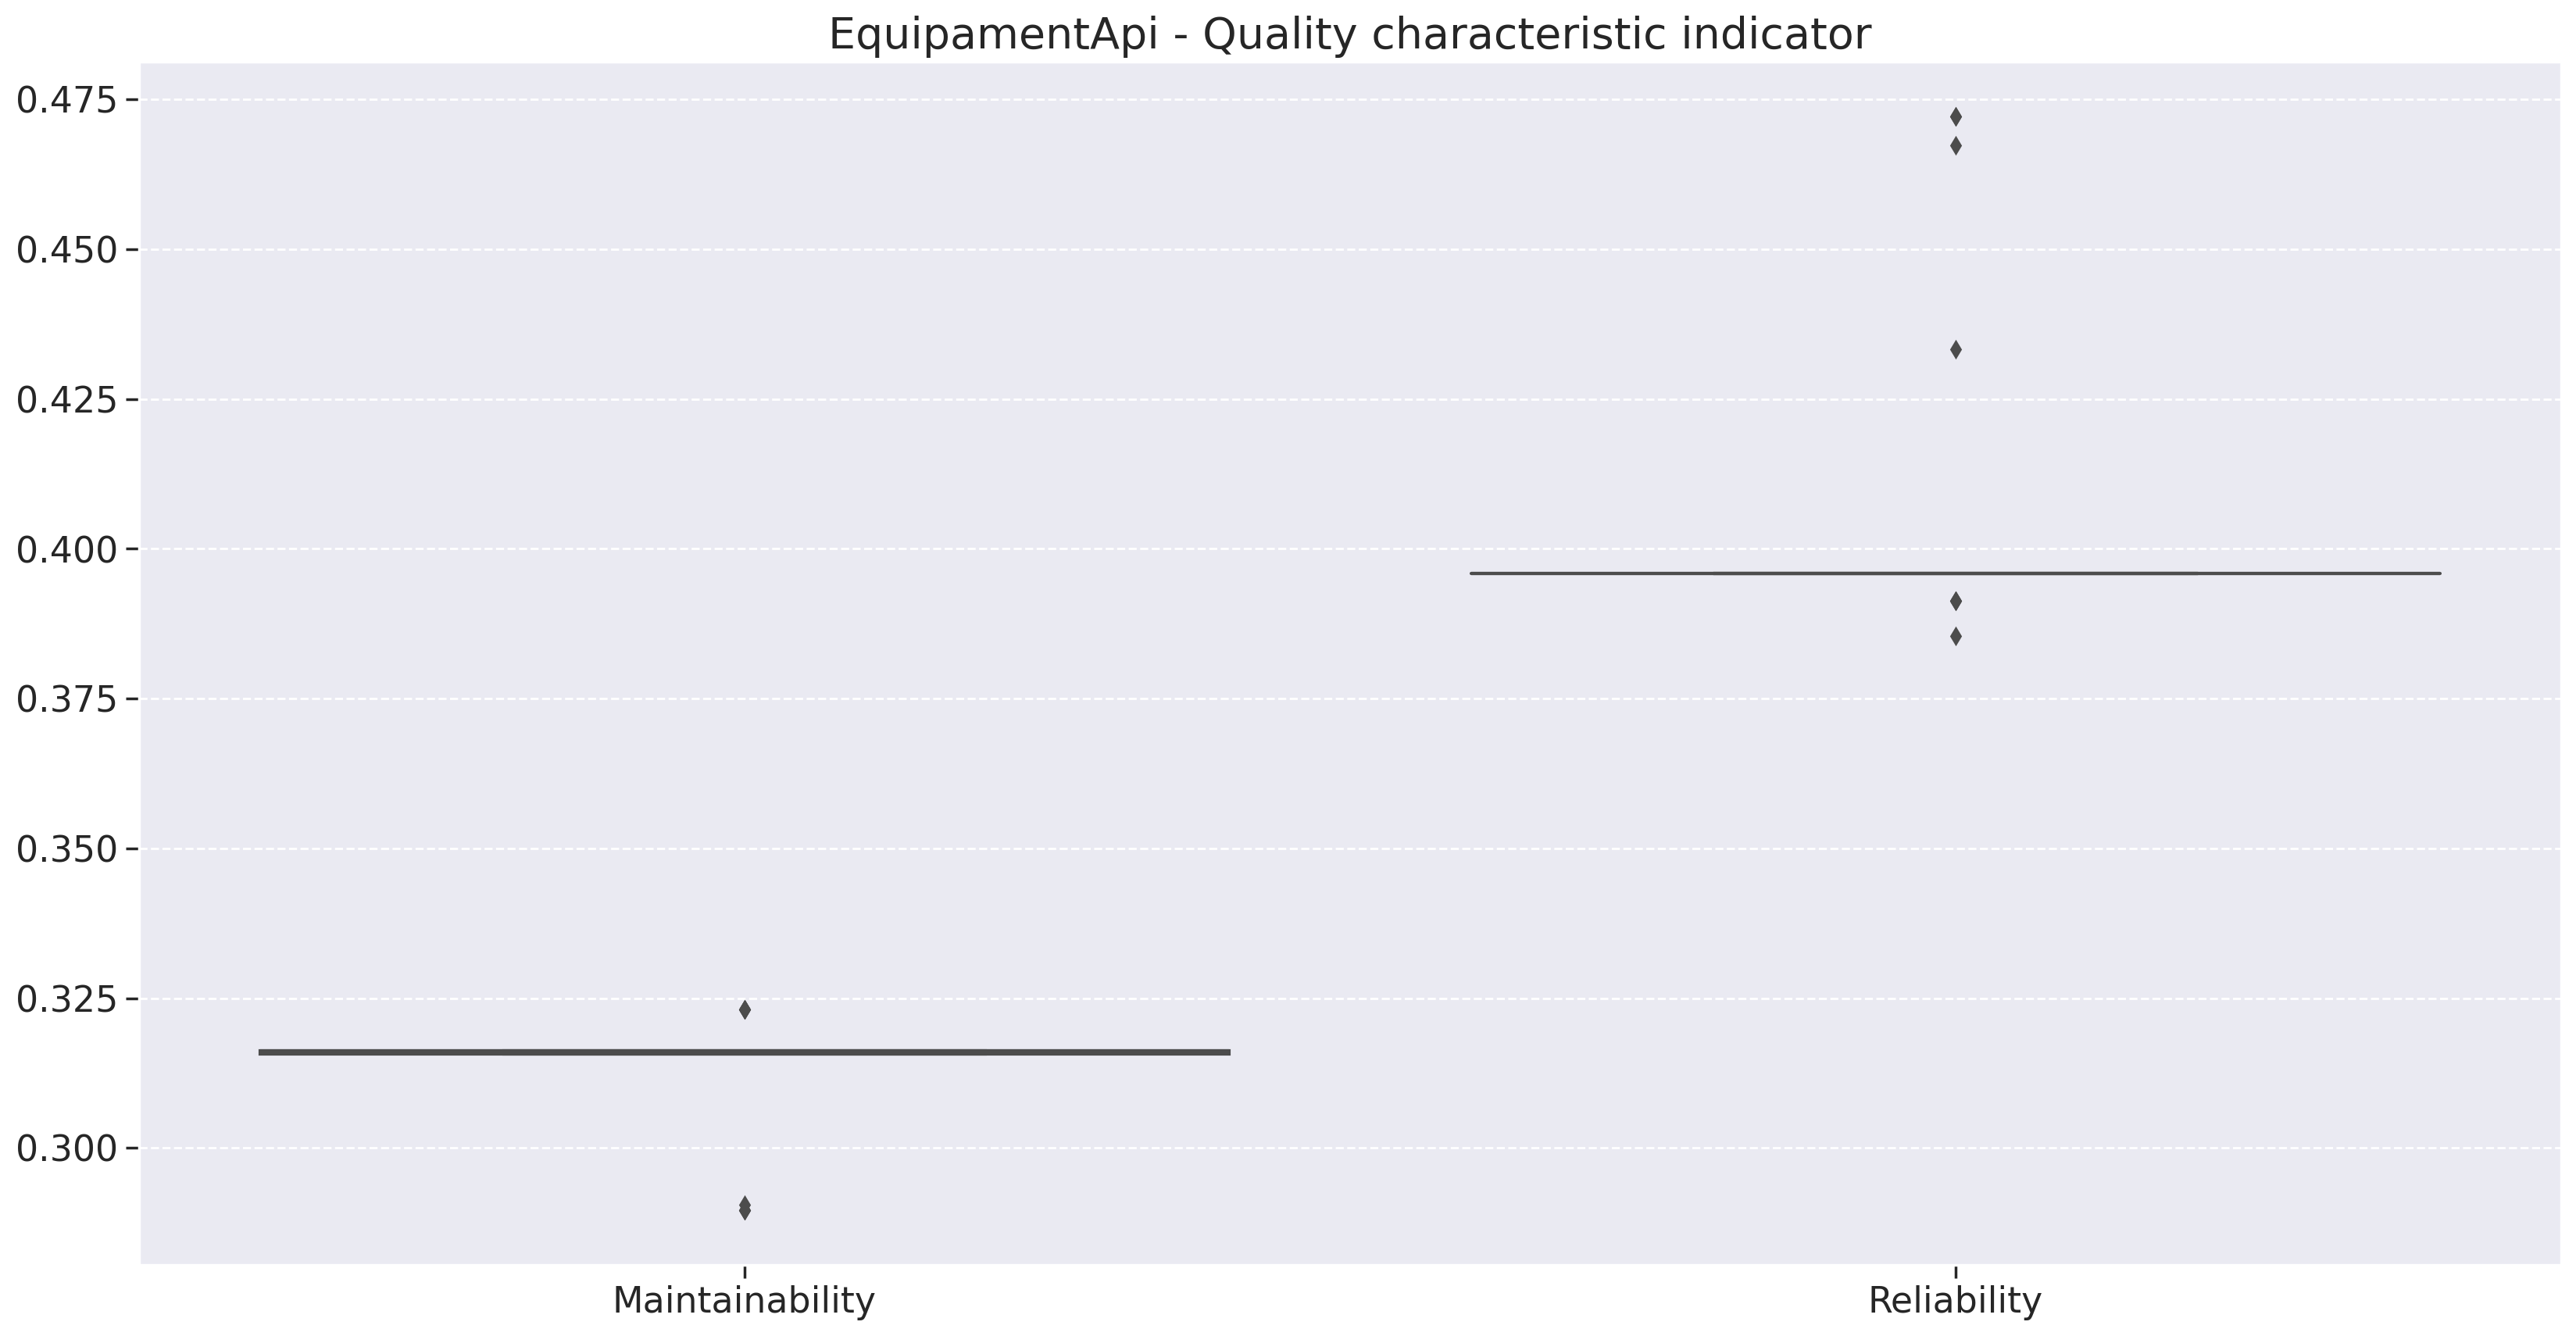

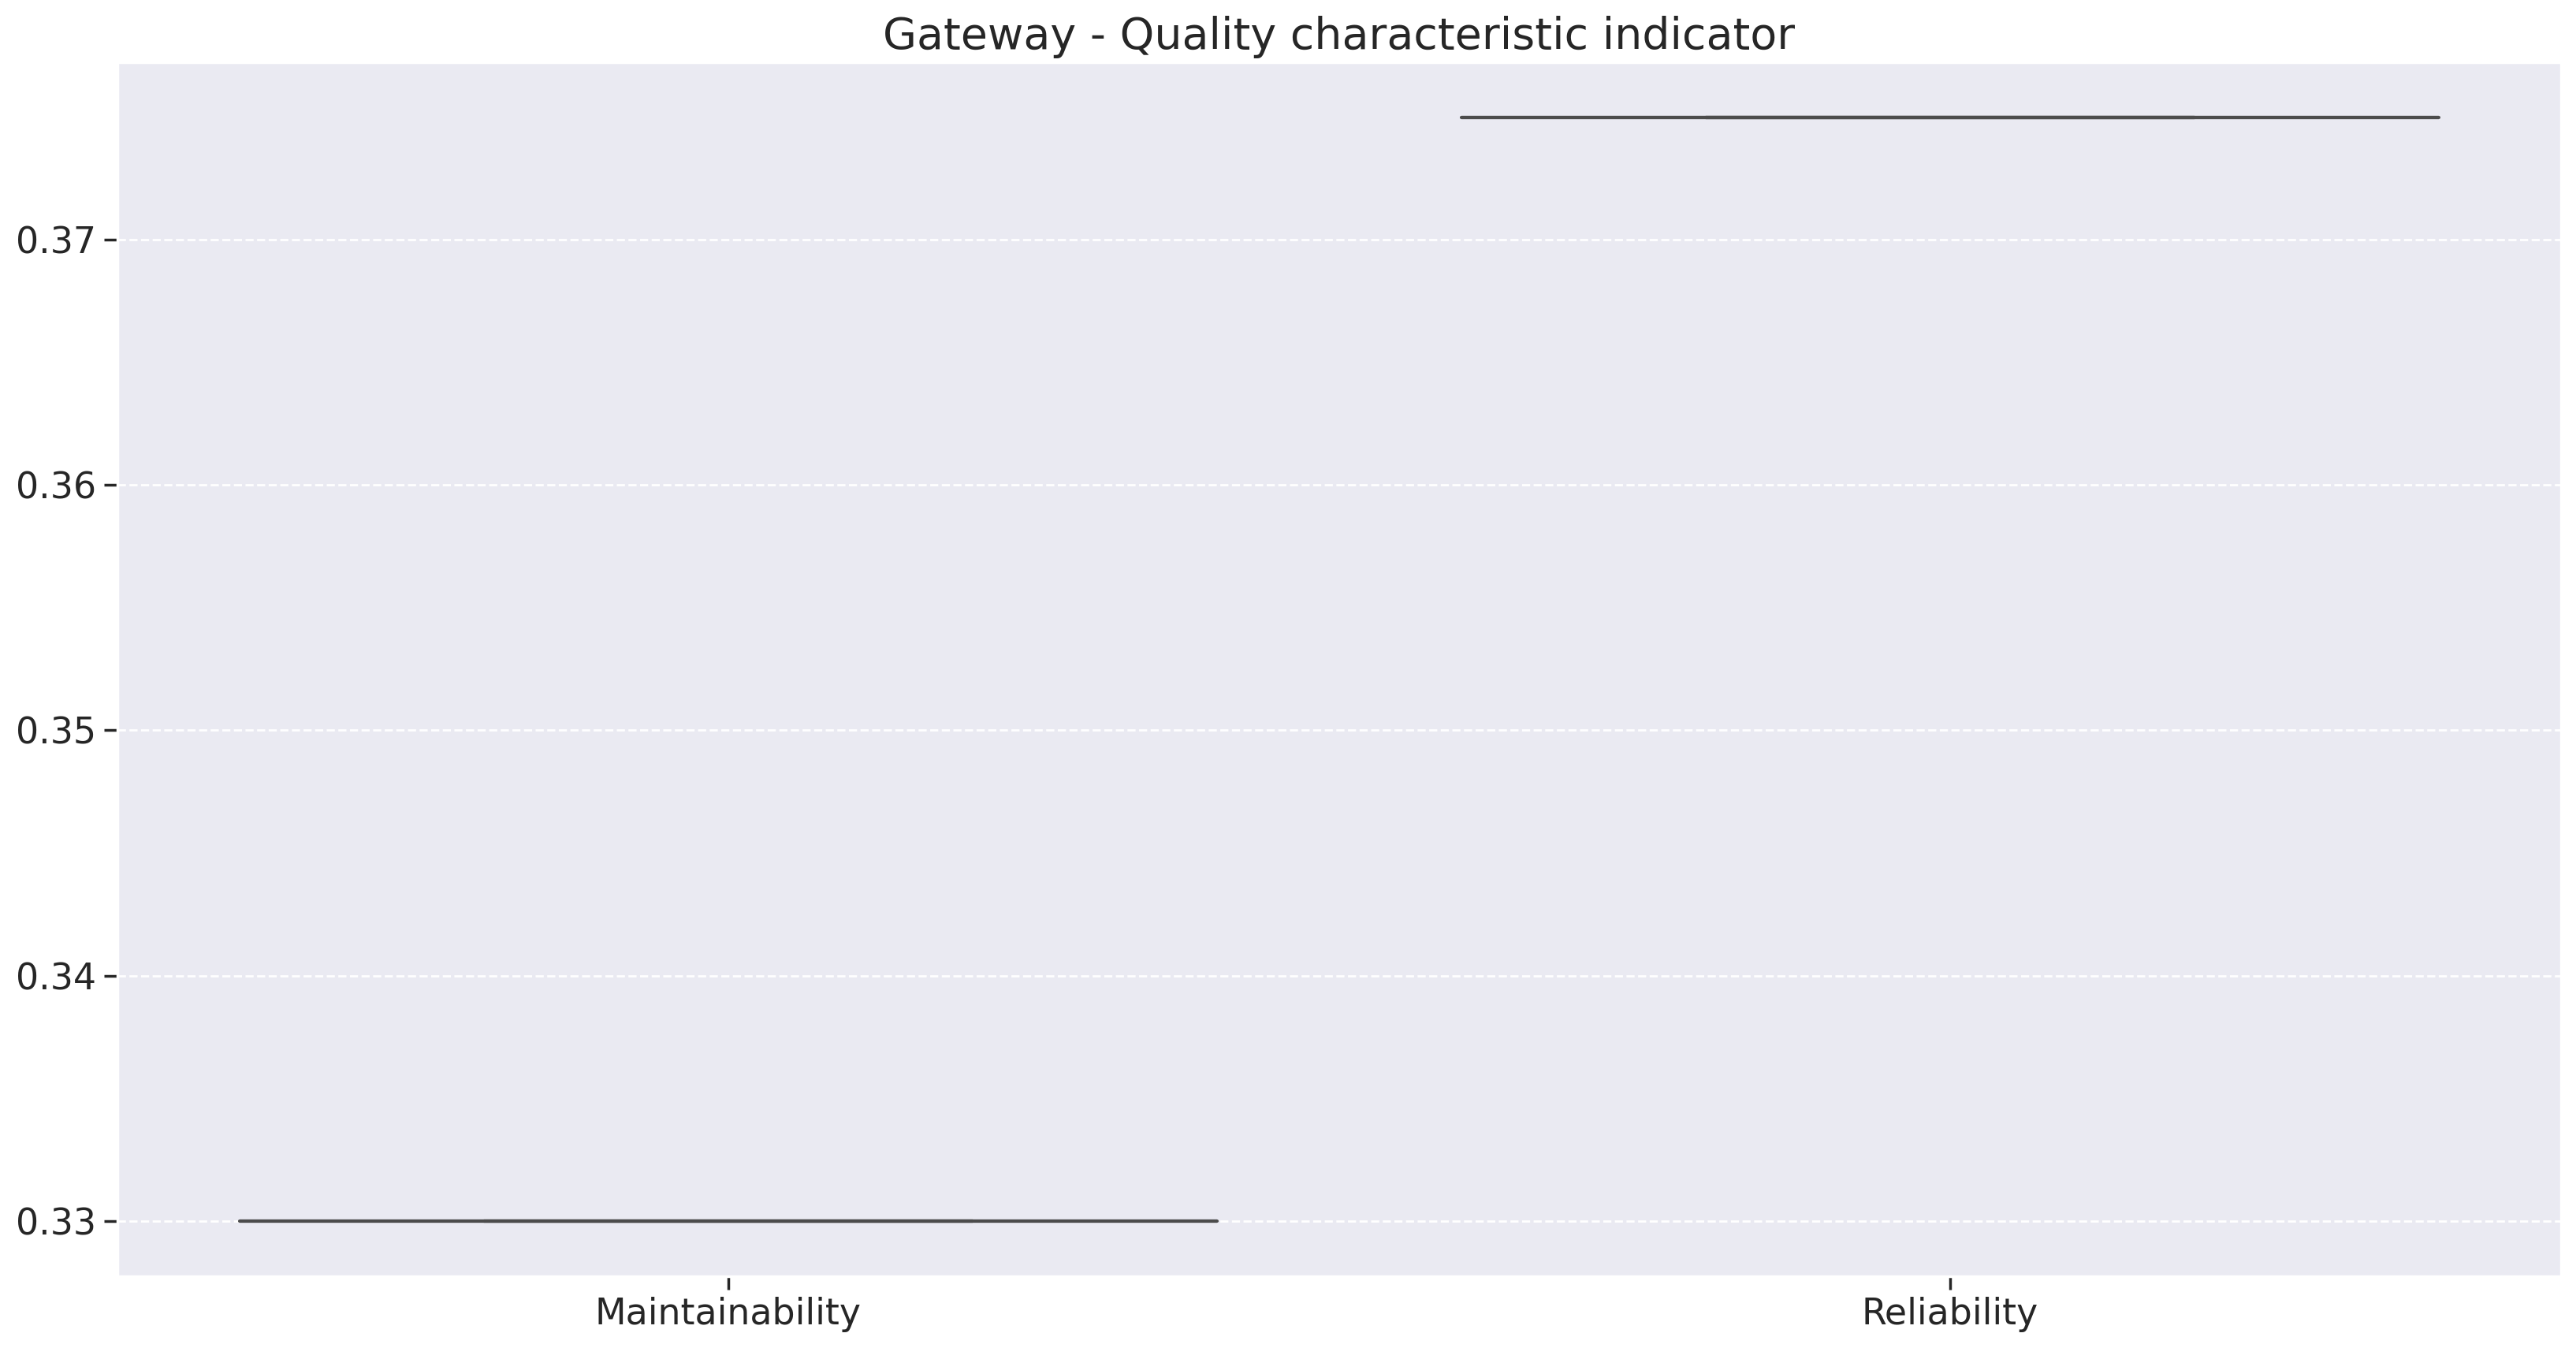

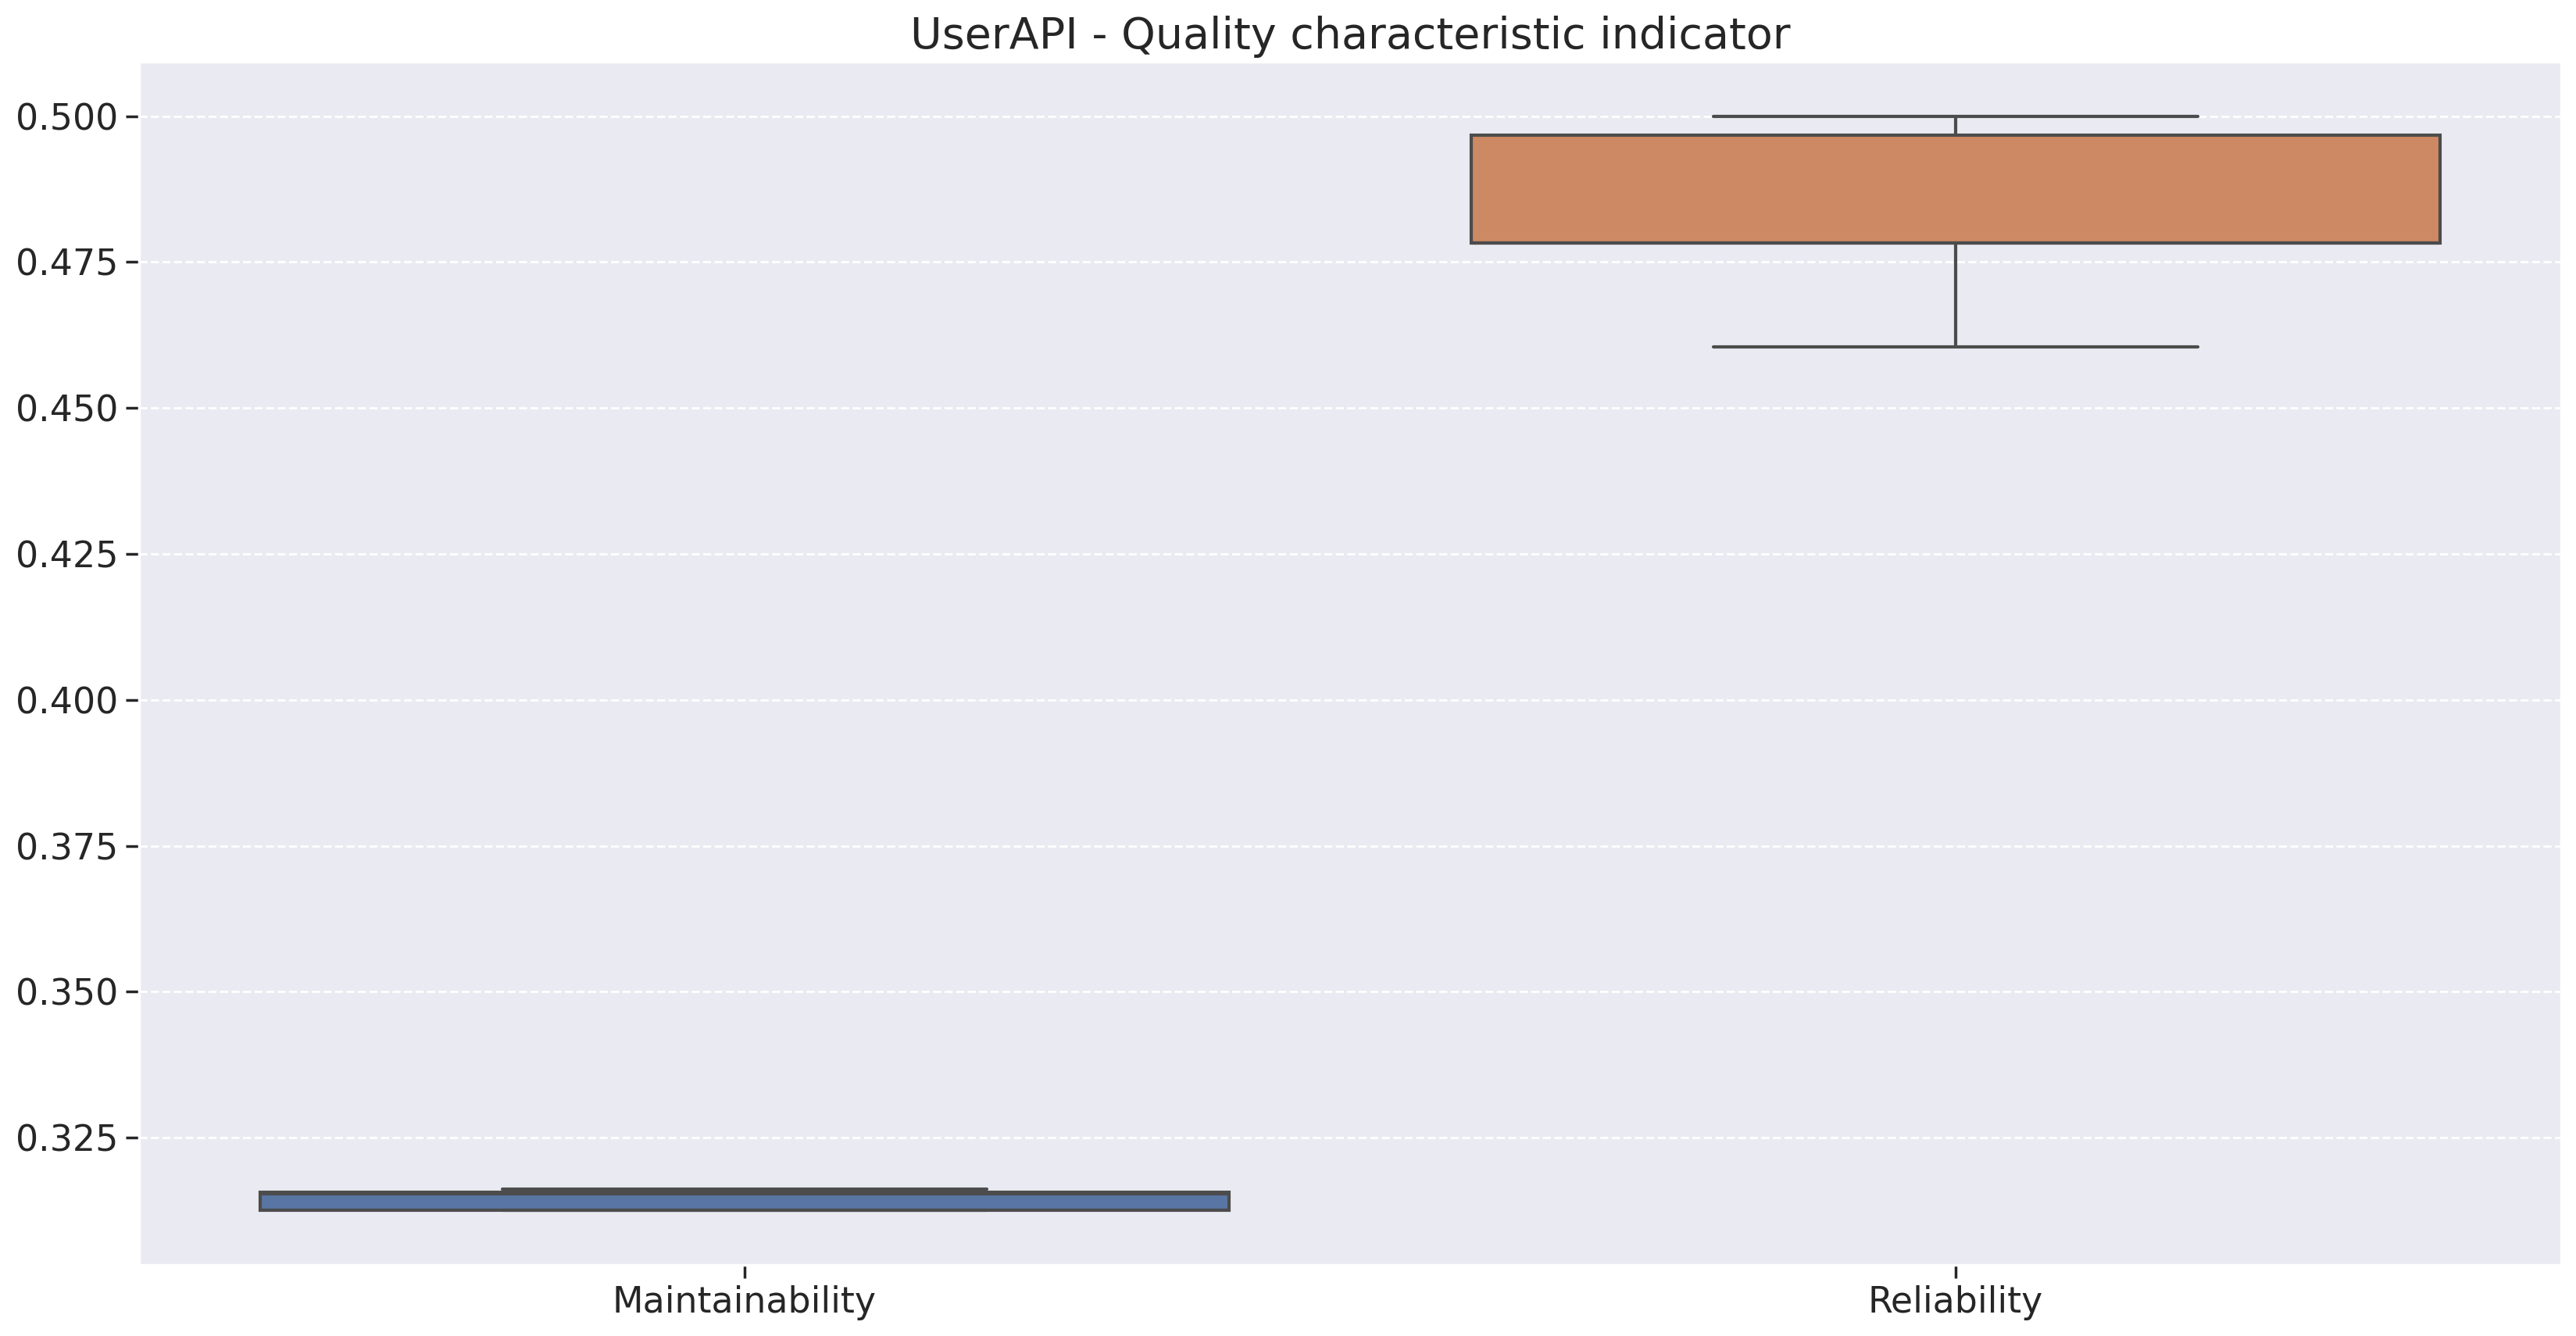

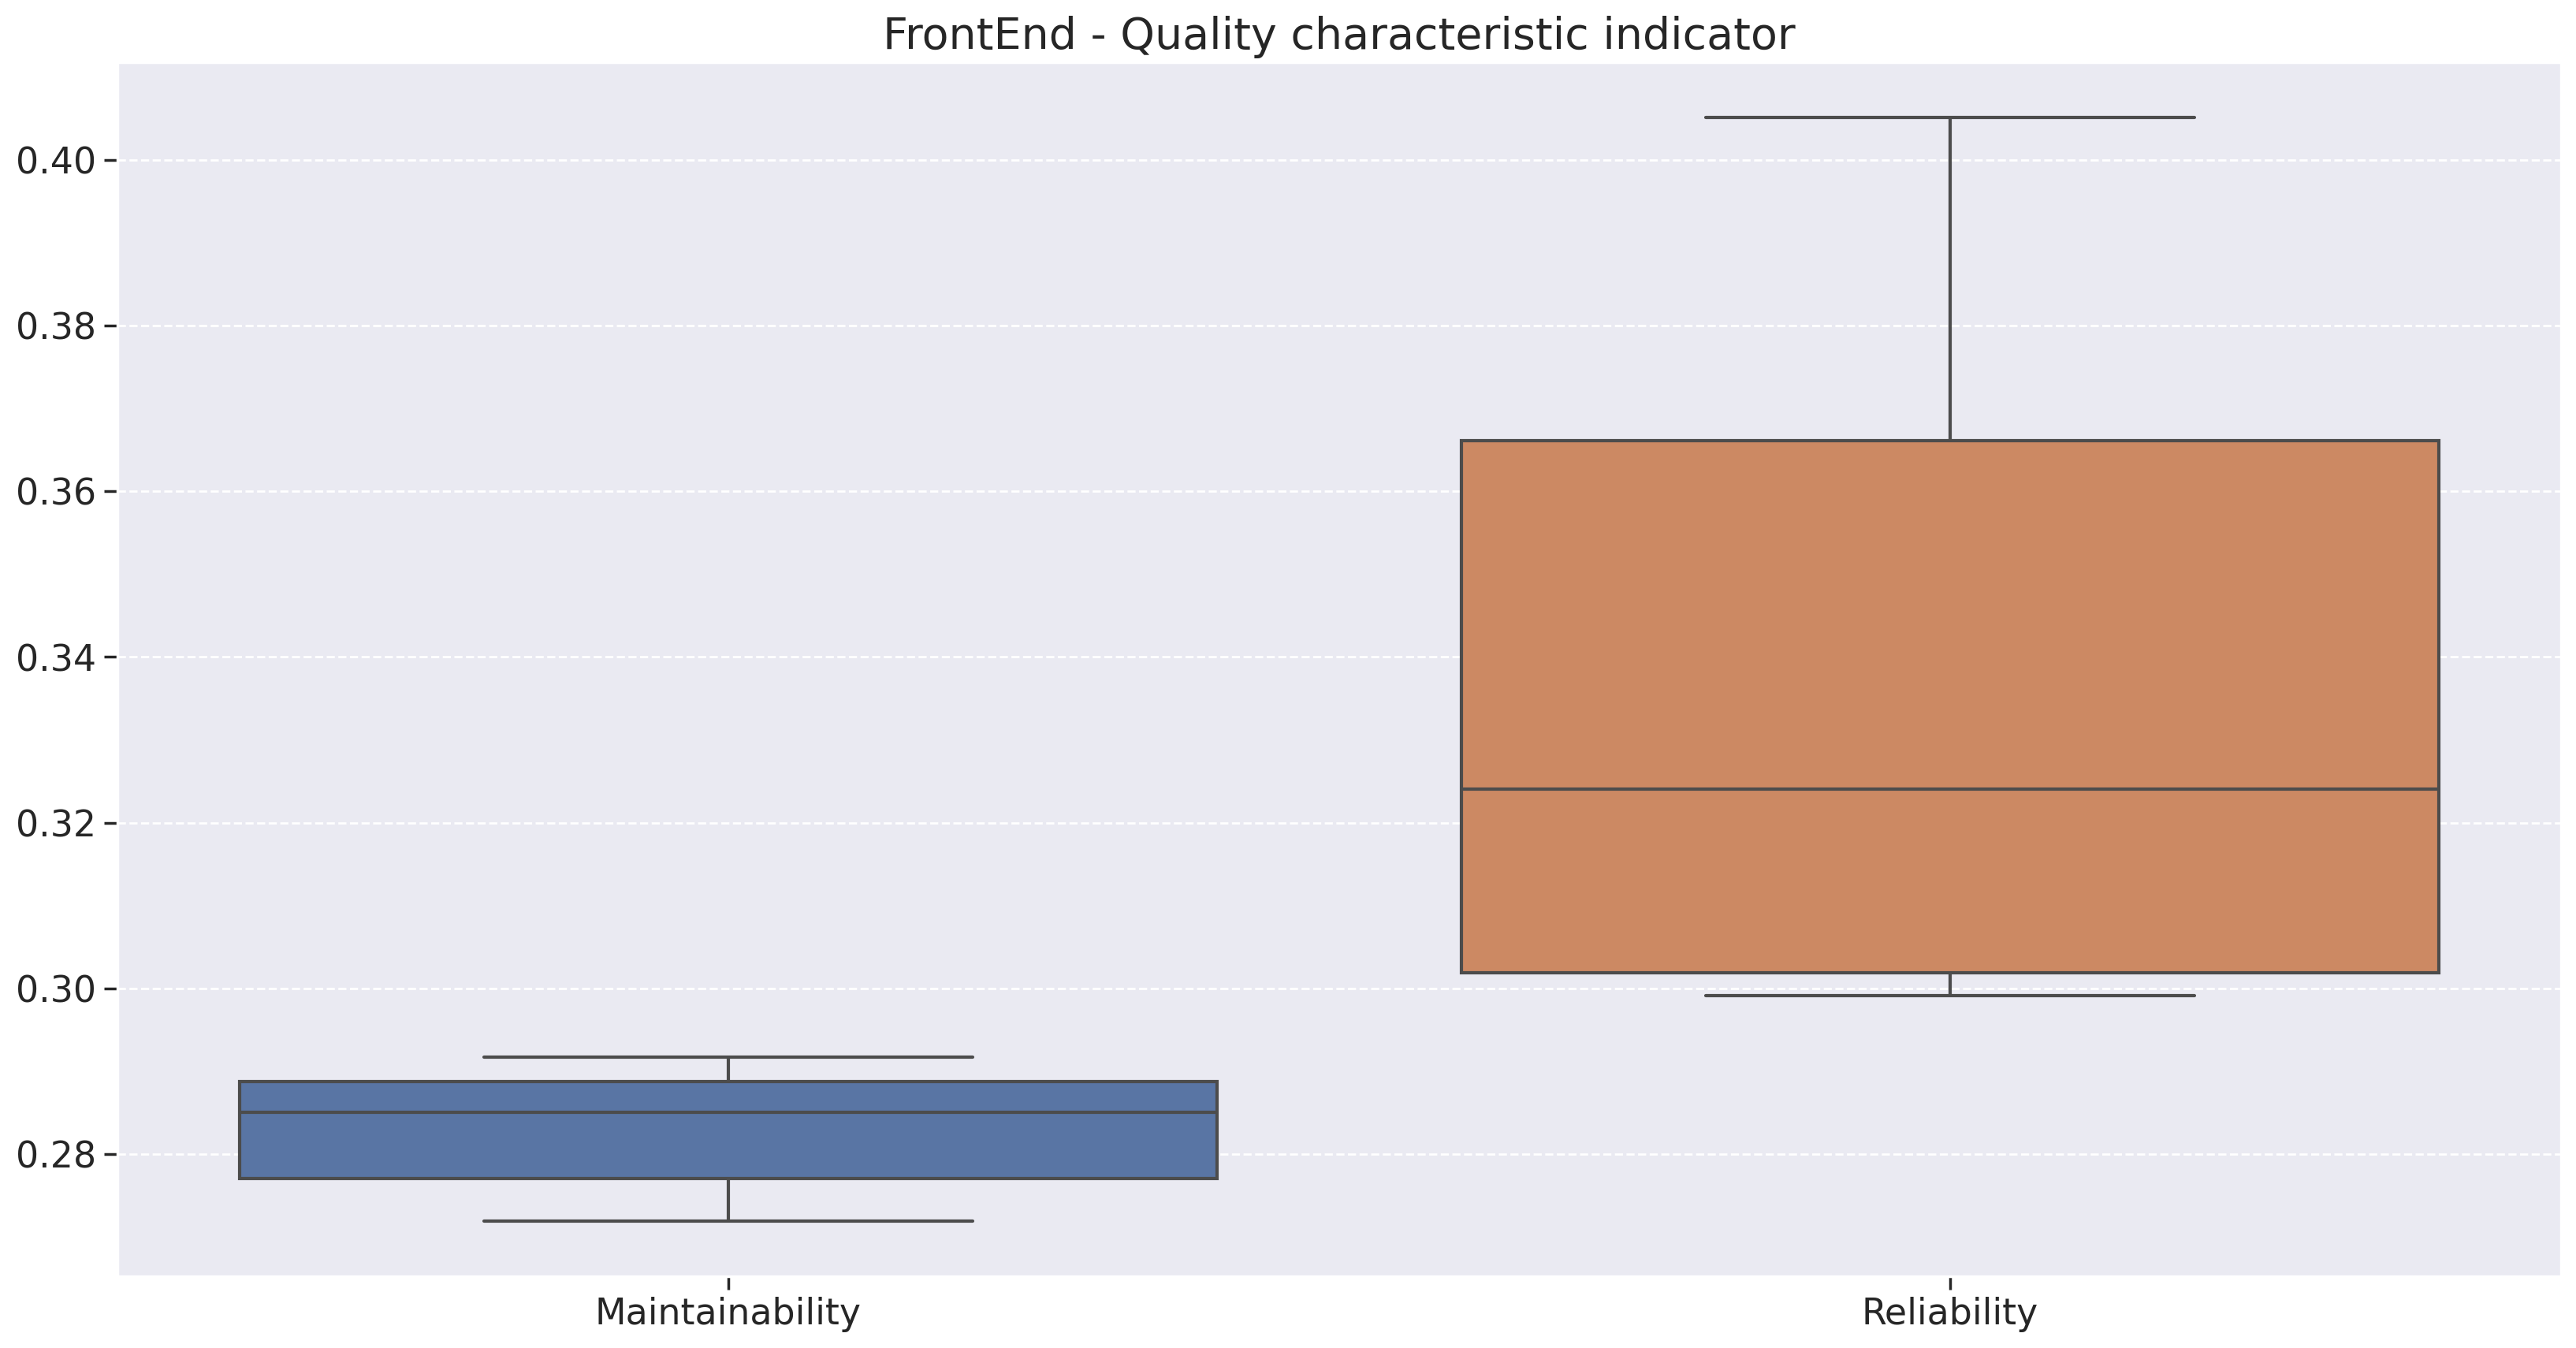

In [31]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

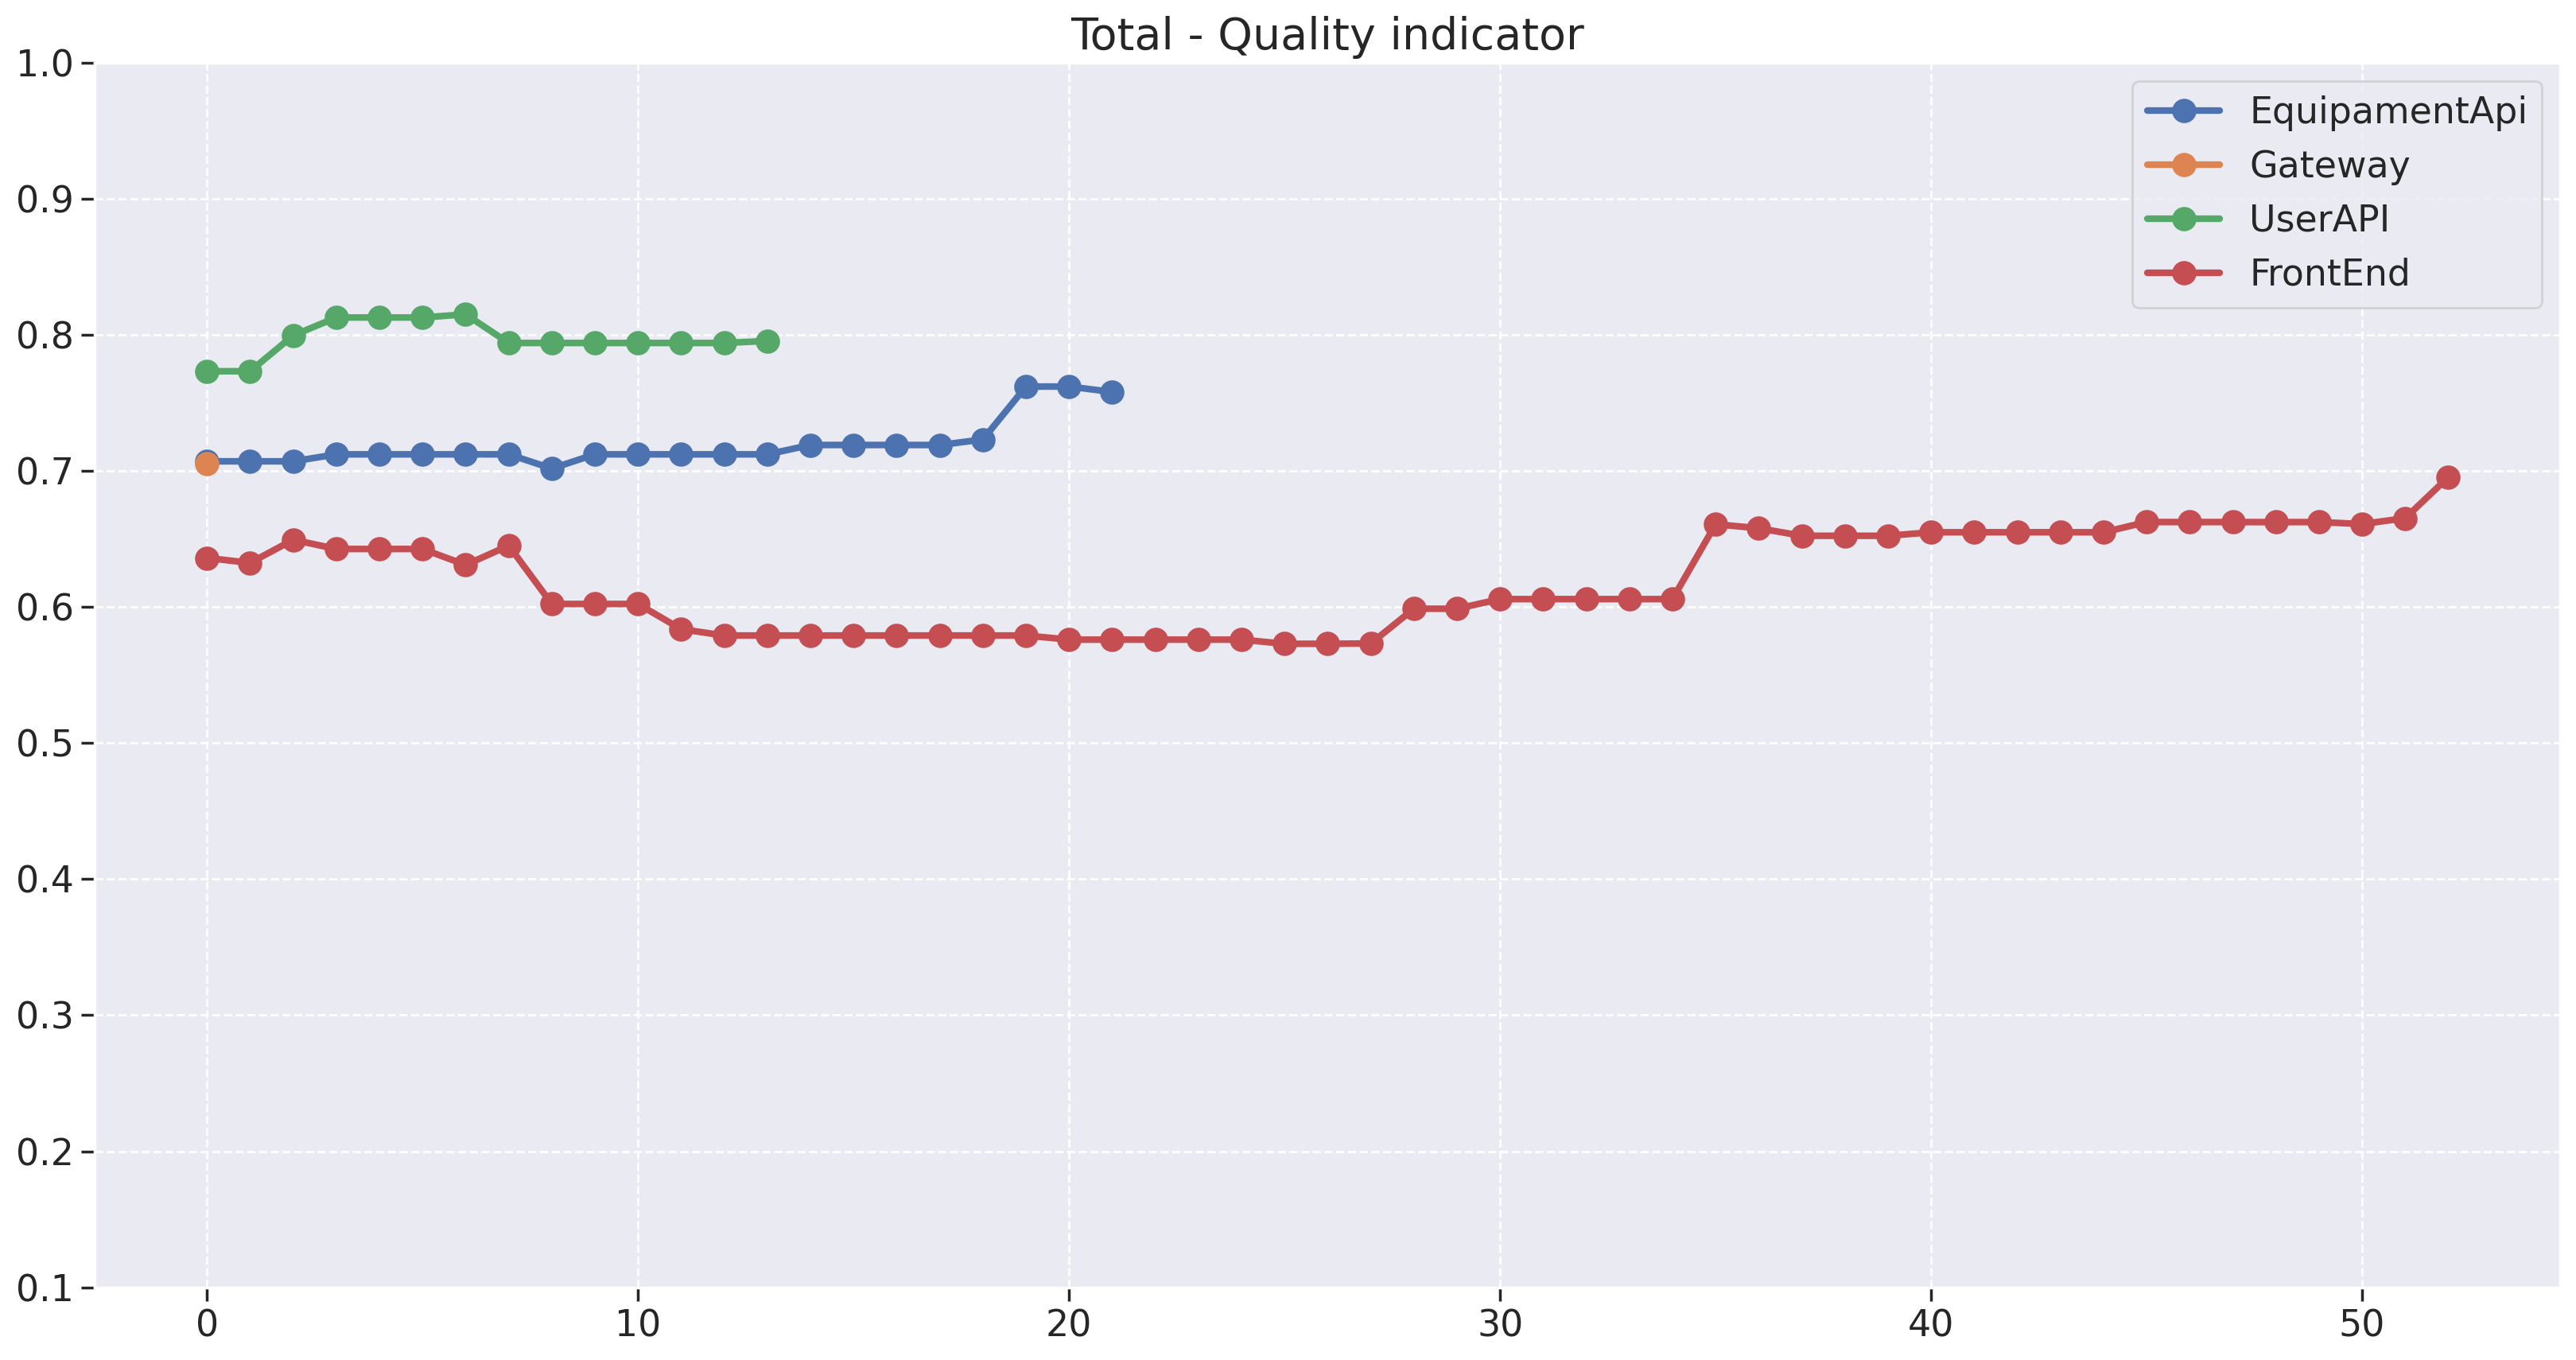

In [32]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [33]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('./data/fga-eps-mds-2023-1-Alectrion--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./data/fga-eps-mds-2023-1-Alectrion--{}.csv'.format(current_datetime), index = False)

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.956522,0.000000,0.956522,1.0,1.0,0.565217,fga-eps-mds-2023-1-Alectrion-EquipamentApi,05-13-2023-17-01-24,5006,0.631304,0.782609,0.315652,0.391304,0.706957
1,0.956522,0.000000,0.956522,1.0,1.0,0.565217,fga-eps-mds-2023-1-Alectrion-EquipamentApi,05-13-2023-18-10-02,5006,0.631304,0.782609,0.315652,0.391304,0.706957
2,0.956522,0.000000,0.956522,1.0,1.0,0.565217,fga-eps-mds-2023-1-Alectrion-EquipamentApi,05-17-2023-22-22-51,5106,0.631304,0.782609,0.315652,0.391304,0.706957
3,0.958333,0.000000,0.958333,1.0,1.0,0.583333,fga-eps-mds-2023-1-Alectrion-EquipamentApi,05-25-2023-13-13-16,5198,0.632500,0.791667,0.316250,0.395833,0.712083
4,0.958333,0.000000,0.958333,1.0,1.0,0.583333,fga-eps-mds-2023-1-Alectrion-EquipamentApi,05-25-2023-21-41-09,5298,0.632500,0.791667,0.316250,0.395833,0.712083
5,0.958333,0.000000,0.958333,1.0,1.0,0.583333,fga-eps-mds-2023-1-Alectrion-EquipamentApi,05-25-2023-22-28-26,5340,0.632500,0.791667,0.316250,0.395833,0.712083
6,0.958333,0.000000,0.958333,1.0,1.0,0.583333,fga-eps-mds-2023-1-Alectrion-EquipamentApi,05-26-2023-18-25-52,5346,0.632500,0.791667,0.316250,0.395833,0.712083
7,0.958333,0.000000,0.958333,1.0,1.0,0.583333,fga-eps-mds-2023-1-Alectrion-EquipamentApi,05-26-2023-20-47-53,5346,0.632500,0.791667,0.316250,0.395833,0.712083
8,0.958333,0.000000,0.958333,1.0,1.0,0.541667,fga-eps-mds-2023-1-Alectrion-EquipamentApi,05-26-2023-23-49-16,5346,0.632500,0.770833,0.316250,0.385417,0.701667
9,0.958333,0.000000,0.958333,1.0,1.0,0.583333,fga-eps-mds-2023-1-Alectrion-EquipamentApi,05-27-2023-01-57-11,5349,0.632500,0.791667,0.316250,0.395833,0.712083


In [34]:
# Análise geral da qualidade do Alectrion - 21/06/2023 (Sprint 08) 

## EquipamentAPI

* A duplicação de código no repositório EquipamentAPI aumentou ainda mas com as últimas features e agora aproxima
de 90% 
* O foco das primeiras sprints foram aumentar a cobertura de código, após isso a cobertura aumentou para 78% 
aproximadamente e permaneceu constante
* A métrica de complexidade do código permaneceu praticamente constante (em 80%) e não há ainda nenhum 
comentário no código.

* A confiabilidade do código caiu para 20%.
Já a manutenibilidade está em 30% e a equipe acredita que seja por conta da quantidade de duplicação.

No geral, os índices pioraram nas últimas semanas e ainda há necessidade de atuar em refatoração visando reduzir a duplicação.

## UserAPI 

* Há uma grande quantidade de código duplicado (100%) e o coverage está em cerca de 80%.
* A complexidade de código estava constante em 84% aproximadamente, mas caiu nas últimas features de usuário 
subiu para 85%

* A confiabilidade e manutenibilidade do código estão entre 20 e 30%.
A equipe acredita que seja por conta da quantidade de code smells e deve melhorar nas próximas sprints.

## FrontEnd

* A equipe percebeu que a duplicação de código no repositório FrontEnd permanece alta, mas 
aumentou mais com as últimas features para cerca de 84%, assim como a complexidade.
* A cobertura de testes caiu para 42% com as últimas features.

* A complexidade e manutenibilidade cairam e estão baixas, entre 20 e 30%.
A equipe acredita que seja por conta de adição de biblioteca externa

No geral, é necessário focar em testes, refatoração para redução de duplicação e remoção de code smells 
e possíveis vulnerabilidades.

## Gateway

Não foi possível analisar, uma vez que não foram liberadas versões de código. No entanto, este repositório serve
apenas para redirecionamento, não são disponibilizadas funcionalidades neste.

# Consideração FINAL

Os indicadores de qualidade estão em cerca de 50% em todos os repositório.

Isto reflete a necessidade da equipe buscar melhores indicadores de qualidades para todos os repositórios do projeto.


SyntaxError: invalid syntax (1091237897.py, line 5)